### Explanation of Data Columns

#### transaction_data.csv, new_transactions.csv:

- **Transaction ID:** Unique transaction Identifier
- **Customer ID:** Unique customer identifier
- **Date:** Date in YYYY/MM/DD format
- **Total Items:** Total items in basket
- **Unique Items:** Unique items in basket
- **Total Sales:** Total expected price
- **Discounted Sales:** Actual price after discounts and vouchers
- **Browsing Duration (minutes):** Time spent browsing on website
- **Number of Clicks:** Actual number of clicks during browsing duration
- **Incomplete Transaction:** Binary outcome of completeness (0 = completed transaction, 1 = incomplete transaction)

#### customer_data.csv:

- **Customer ID:** Unique customer identifier
- **Age:** Age of customer
- **Gender:** Customer’s gender
- **Region:** Region characteristic of customer’s household
- **Marital Status:** Customer marital status
- **Education:** Different levels of maximum education level for customer
- **Household Income:** Total annual income on household
- **Loyalty Card:** Customer has loyalty card (0 = No, 1 = Yes)
- **Loyalty Points:** Loyalty points per customer at the end of the analysis period


# Explain
- Methodology 
- The output of the model you used
- How the output can be used to influence digital sales strategy (regarding incomplete baskets)
- Additional data you could ask to enhance your analysis
- Explanation of metrics used to assess the predictive value of your model
- Any Caveats and additional research you would need to do to make the results more accurate

# Notes 
- we drop Customer ID , Transaction ID , Date
- the Date can have some information about the days of the week that we can use . check it later 
- i did not trasform the numerical feature distributon. some of them are not nromal. we can check this later.
- some algorithms have class weight hyperparameters that we can use
- difference between the normalization and the standard scaling
- try label encodeing on catgorical variables and then standard scaling them 
- try normalization on those numeric feature **without normal distribution** and try standard scaling on those numeric feature **with normal distribution**
    - i tried this and a little improved the recall and percision 
- I also implemented different costs in the support vector machine, which helped.
- feature selection

# Techniques to Tackle the Trade-Off
- Threshold Adjustment: Most classifiers predict probabilities. By adjusting the prediction threshold, you can influence the precision-recall trade-off. A higher threshold boosts precision but lowers recall, and vice versa.
- Resampling Techniques: These involve oversampling the minority class or undersampling the majority class to create a more balanced training dataset.
- Cost-Sensitive Learning: Assign different misclassification costs to different classes, guiding the model to focus on the minority class.

# observation
- normalization of numeric reduced the recall for Xgboost drastically and increase the precision.
- tiil now the best result is for standard scaller, onehot encoding, under sampling  on XGboost
-untill now the be

# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

import joblib
import os
from datetime import datetime


import random
random.seed(42)
np.random.seed(42)
# Modelling
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

from sklearn.svm import SVC


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTETomek


from imblearn.pipeline import  make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold


from sklearn.base import clone 

#  Define a colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()


# from tensorflow import keras


In [2]:
# Load data
transaction_data = pd.read_csv(r'C:\Users\layeg\Desktop\GitHub\Holland_and_Barret\notebook\data\data\transactions_data.csv')
customer_data = pd.read_csv(r'C:\Users\layeg\Desktop\GitHub\Holland_and_Barret\notebook\data\data\customer_data.csv')
new_transactions = pd.read_csv(r'C:\Users\layeg\Desktop\GitHub\Holland_and_Barret\notebook\data\data\new_transactions.csv')

In [3]:

# Merge transaction and customer data on 'Customer ID'
df = pd.merge(transaction_data, customer_data, on='Customer ID', how='left')

#drop Customer ID , Transaction ID , Date
#df = df.drop(['Customer ID', 'Transaction ID', 'Date'], axis=1 , inplace=True)

display(df.shape)
display(df.head())
display(df.info())
display(df.describe())

(5000, 18)

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction,Age,Gender,Region,Marital Status,Education,Household Income,Loyalty Card,Loyalty Points
0,TRID_21210,CID_12160,2020-03-22,8,3,22.88,7.54,3.11,7,0,19,Female,Rural,Divorced,High School,21000.0,0,NaN
1,TRID_83725,CID_11410,2020-01-08,4,2,22.80,4.79,7.51,15,0,41,Female,Urban,Divorced,High School,20000.0,1,5.0
2,TRID_10532,CID_12776,2020-02-19,5,3,14.80,7.96,8.98,16,0,42,Female,Urban,Married,Graduate,9000.0,0,NaN
3,TRID_88885,CID_9162,2020-02-17,5,3,13.04,6.98,5.61,11,0,77,Male,Urban,Divorced,High School,84500.0,1,21.0
4,TRID_68790,CID_14594,2020-01-06,14,4,9.60,9.25,6.62,14,1,30,Male,Rural,Single,Graduate,53500.0,0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               5000 non-null   object 
 1   Customer ID                  5000 non-null   object 
 2   Date                         5000 non-null   object 
 3   Total Items                  5000 non-null   int64  
 4   Unique Items                 5000 non-null   int64  
 5   Total Sales                  5000 non-null   float64
 6   Discounted Sales             5000 non-null   float64
 7   Browsing Duration (minutes)  5000 non-null   float64
 8   Number of Clicks             5000 non-null   int64  
 9   Incomplete Transaction       5000 non-null   int64  
 10  Age                          5000 non-null   int64  
 11  Gender                       5000 non-null   object 
 12  Region                       5000 non-null   object 
 13  Marital Status    

None

,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction,Age,Household Income,Loyalty Card,Loyalty Points
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,2435.000000
mean,5.508200,3.016400,13.711920,7.069330,5.760234,11.622200,0.20000,47.652200,47157.100000,0.487000,17.243121
std,2.584815,1.007141,5.639713,1.947033,1.857751,3.379371,0.40004,17.422432,24303.324874,0.499881,11.723395
min,1.000000,0.000000,2.640000,0.750000,1.000000,4.000000,0.00000,18.000000,5500.000000,0.000000,0.000000
25%,4.000000,2.000000,9.680000,5.770000,4.500000,9.000000,0.00000,32.000000,26500.000000,0.000000,8.000000
50%,5.000000,3.000000,12.560000,7.080000,5.720000,11.000000,0.00000,48.000000,47000.000000,0.000000,16.000000
75%,7.000000,4.000000,16.560000,8.390000,7.040000,14.000000,0.00000,62.000000,68500.000000,1.000000,25.000000
max,20.000000,7.000000,46.560000,14.460000,11.860000,23.000000,1.00000,77.000000,89500.000000,1.000000,63.000000


In [9]:
# df2 = pd.merge(new_transactions, customer_data, on='Customer ID', how='left')
# df2.to_csv(r'C:\Users\layeg\Desktop\GitHub\Holland_Barret\research\notebook\data\data\new_transactions_merged_data.csv', index=False)

# save merged dataframe as a csv file
# df.to_csv(r'C:\Users\layeg\Desktop\GitHub\Holland_Barret\research\notebook\data\data\merged_data.csv', index=False)



# Duplicate check

In [338]:
df[df.duplicated()].shape

(0, 18)

# Null Values

In [339]:
df.isnull().sum()

Transaction ID                    0
Customer ID                       0
Date                              0
Total Items                       0
Unique Items                      0
Total Sales                       0
Discounted Sales                  0
Browsing Duration (minutes)       0
Number of Clicks                  0
Incomplete Transaction            0
Age                               0
Gender                            0
Region                            0
Marital Status                    0
Education                       407
Household Income                  0
Loyalty Card                      0
Loyalty Points                 2565
dtype: int64

- Almost 50% of Loyality  Points values are NUll
- education also has some null values 

# Balance Check

In [340]:
#check balance of the data
df['Incomplete Transaction'].value_counts()

Incomplete Transaction
0    4000
1    1000
Name: count, dtype: int64

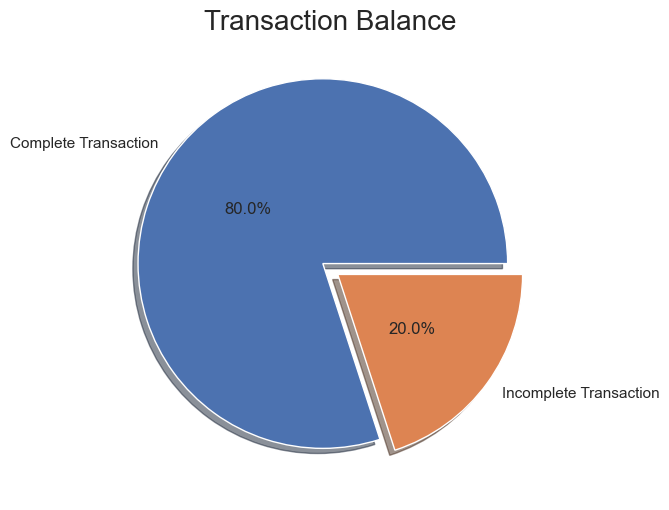

In [341]:
labels = ['Complete Transaction', 'Incomplete Transaction']
data = [df['Incomplete Transaction'].value_counts()[0],
         df['Incomplete Transaction'].value_counts()[1]
        ]
fig1, ax1 = plt.subplots(figsize=[15,6])
ax1.pie(data, labels=labels,explode=[0.05]*2, autopct='%1.1f%%',pctdistance=0.5, shadow=True)
plt.title("Transaction Balance", fontsize=20)
plt.show()

**Report**
- The target classes are highly imbalanced
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. 
- Hence we should handle imbalanced data with certain methods.

**How to handle Imbalance Data ?**

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- **SMOTE:** Synthetic Minority Oversampling Technique
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

# Feature Engineering

## Total Discount Percentage 

In [342]:
df['Discount Percentage'] = ((df['Total Sales'] - df['Discounted Sales']) / df['Total Sales']) * 100

## Unique Items per total item Ratio:


In [343]:
df['Unique Items per Total Item'] = df['Unique Items'] / df['Total Items']


## Seasonality Indicator:

In [344]:
df['Month'] = pd.to_datetime(df['Date']).dt.month


## Drop columns

In [345]:
# drop useless columns for ML analysis ( we already used Date for getting the Month Feature)
#drop Customer ID , Transaction ID , Date
df.drop(columns=['Customer ID', 'Transaction ID','Date'], inplace=True)

In [346]:

#df.drop(columns=['Discounted Sales', 'Number of Clicks'], inplace=True)

In [347]:
df['Month']=df['Month'].astype(str)
df['Loyalty Card'] = df['Loyalty Card'].astype(str)

# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# numeric_features = ['Total Items', 'Unique Items', 'Total Sales', 'Discounted Sales', 'Browsing Duration (minutes)', 'Number of Clicks', 'Age', 'Household Income', 'Loyalty Points', "Discount Percentage", 'Unique Items per Total Item']
# categorical_features = [ 'Gender', 'Region', 'Marital Status', 'Education', 'Incomplete Transaction', 'Loyalty Card', 'Month']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 12 numerical features : ['Total Items', 'Unique Items', 'Total Sales', 'Discounted Sales', 'Browsing Duration (minutes)', 'Number of Clicks', 'Incomplete Transaction', 'Age', 'Household Income', 'Loyalty Points', 'Discount Percentage', 'Unique Items per Total Item']

We have 6 categorical features : ['Gender', 'Region', 'Marital Status', 'Education', 'Loyalty Card', 'Month']


# EDA

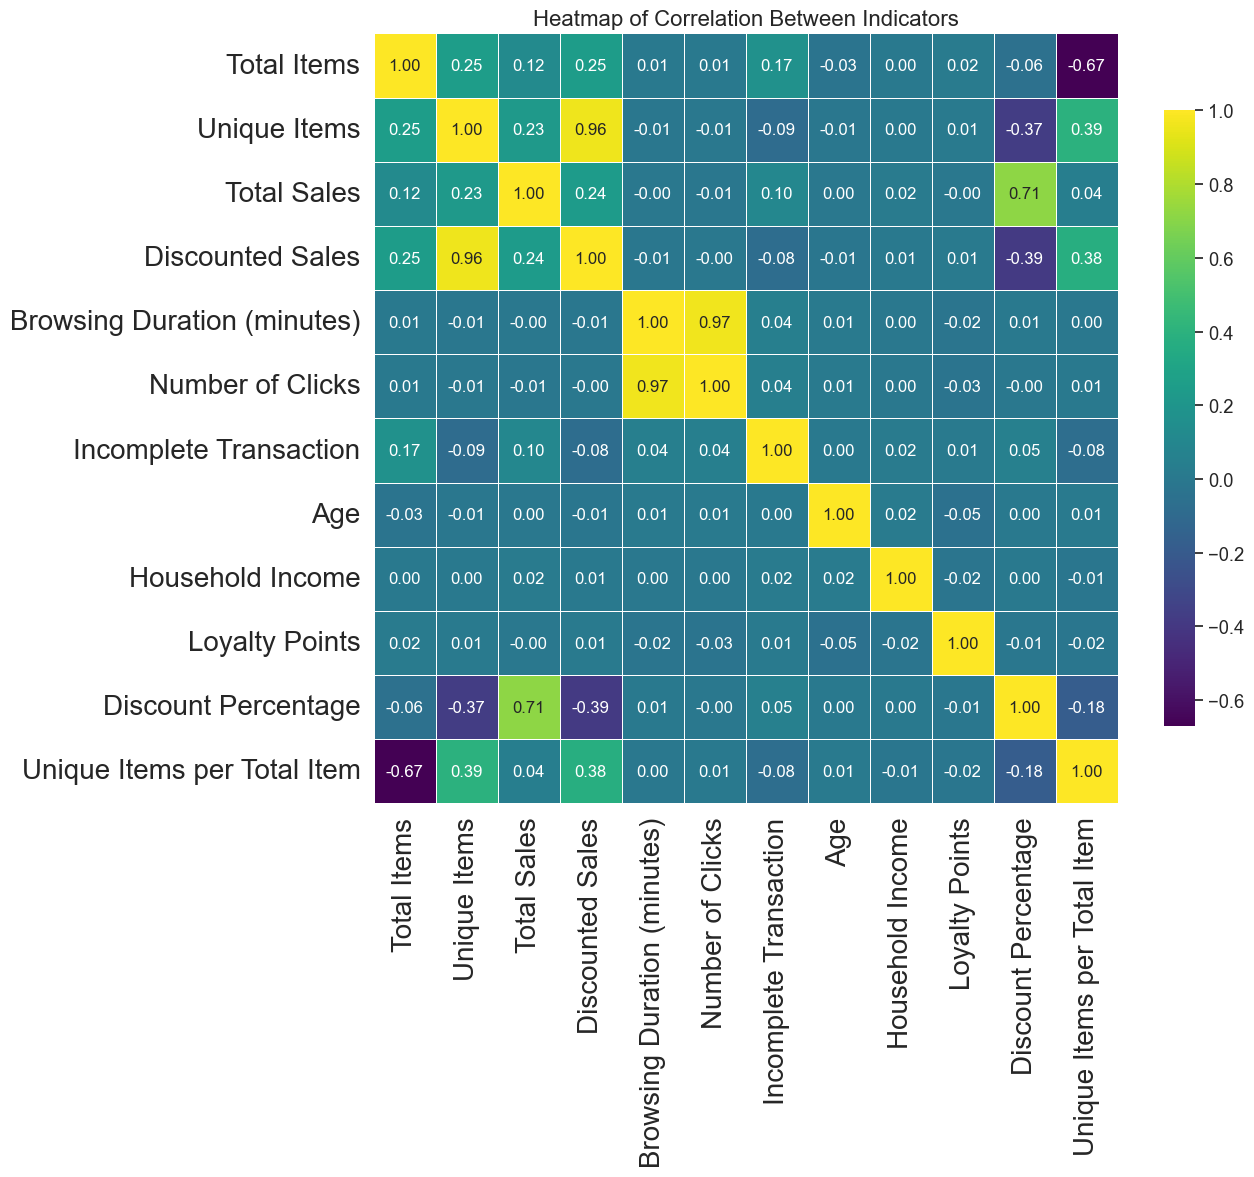

In [278]:
def generate_correlation_heatmap(dataframe):
    # Select only the numeric columns for correlation
    numeric_df = dataframe.select_dtypes(include=[np.number])

    # Calculate the correlation matrix
    correlation_matrix = numeric_df.corr()

    # Create a heatmap
    plt.figure(figsize=(12, 10))  # Make it bigger
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='viridis',  # A different color palette
                linewidths=.5,  # Add lines between squares
                fmt=".2f",  # Limit decimal points
                cbar_kws={"shrink": .8},
                annot_kws={'size': 12})  # Adjust color bar size

    plt.title('Heatmap of Correlation Between Indicators', fontsize=16)
    plt.xticks(fontsize=20)  # Reduce font size for x labels
    plt.yticks(fontsize=20)  # Reduce font size for y labels
    plt.show()

generate_correlation_heatmap(df)

- Number of clicks and the Browing Duration seems highly correlated also Discounted Sales unique items 
- we drop Discounted Sales  becuase we use it to calculate discount percentage and drop Number of Clicks becuase it destribution is less normall compare to  Browing  Duration 


## Bivariant analysis

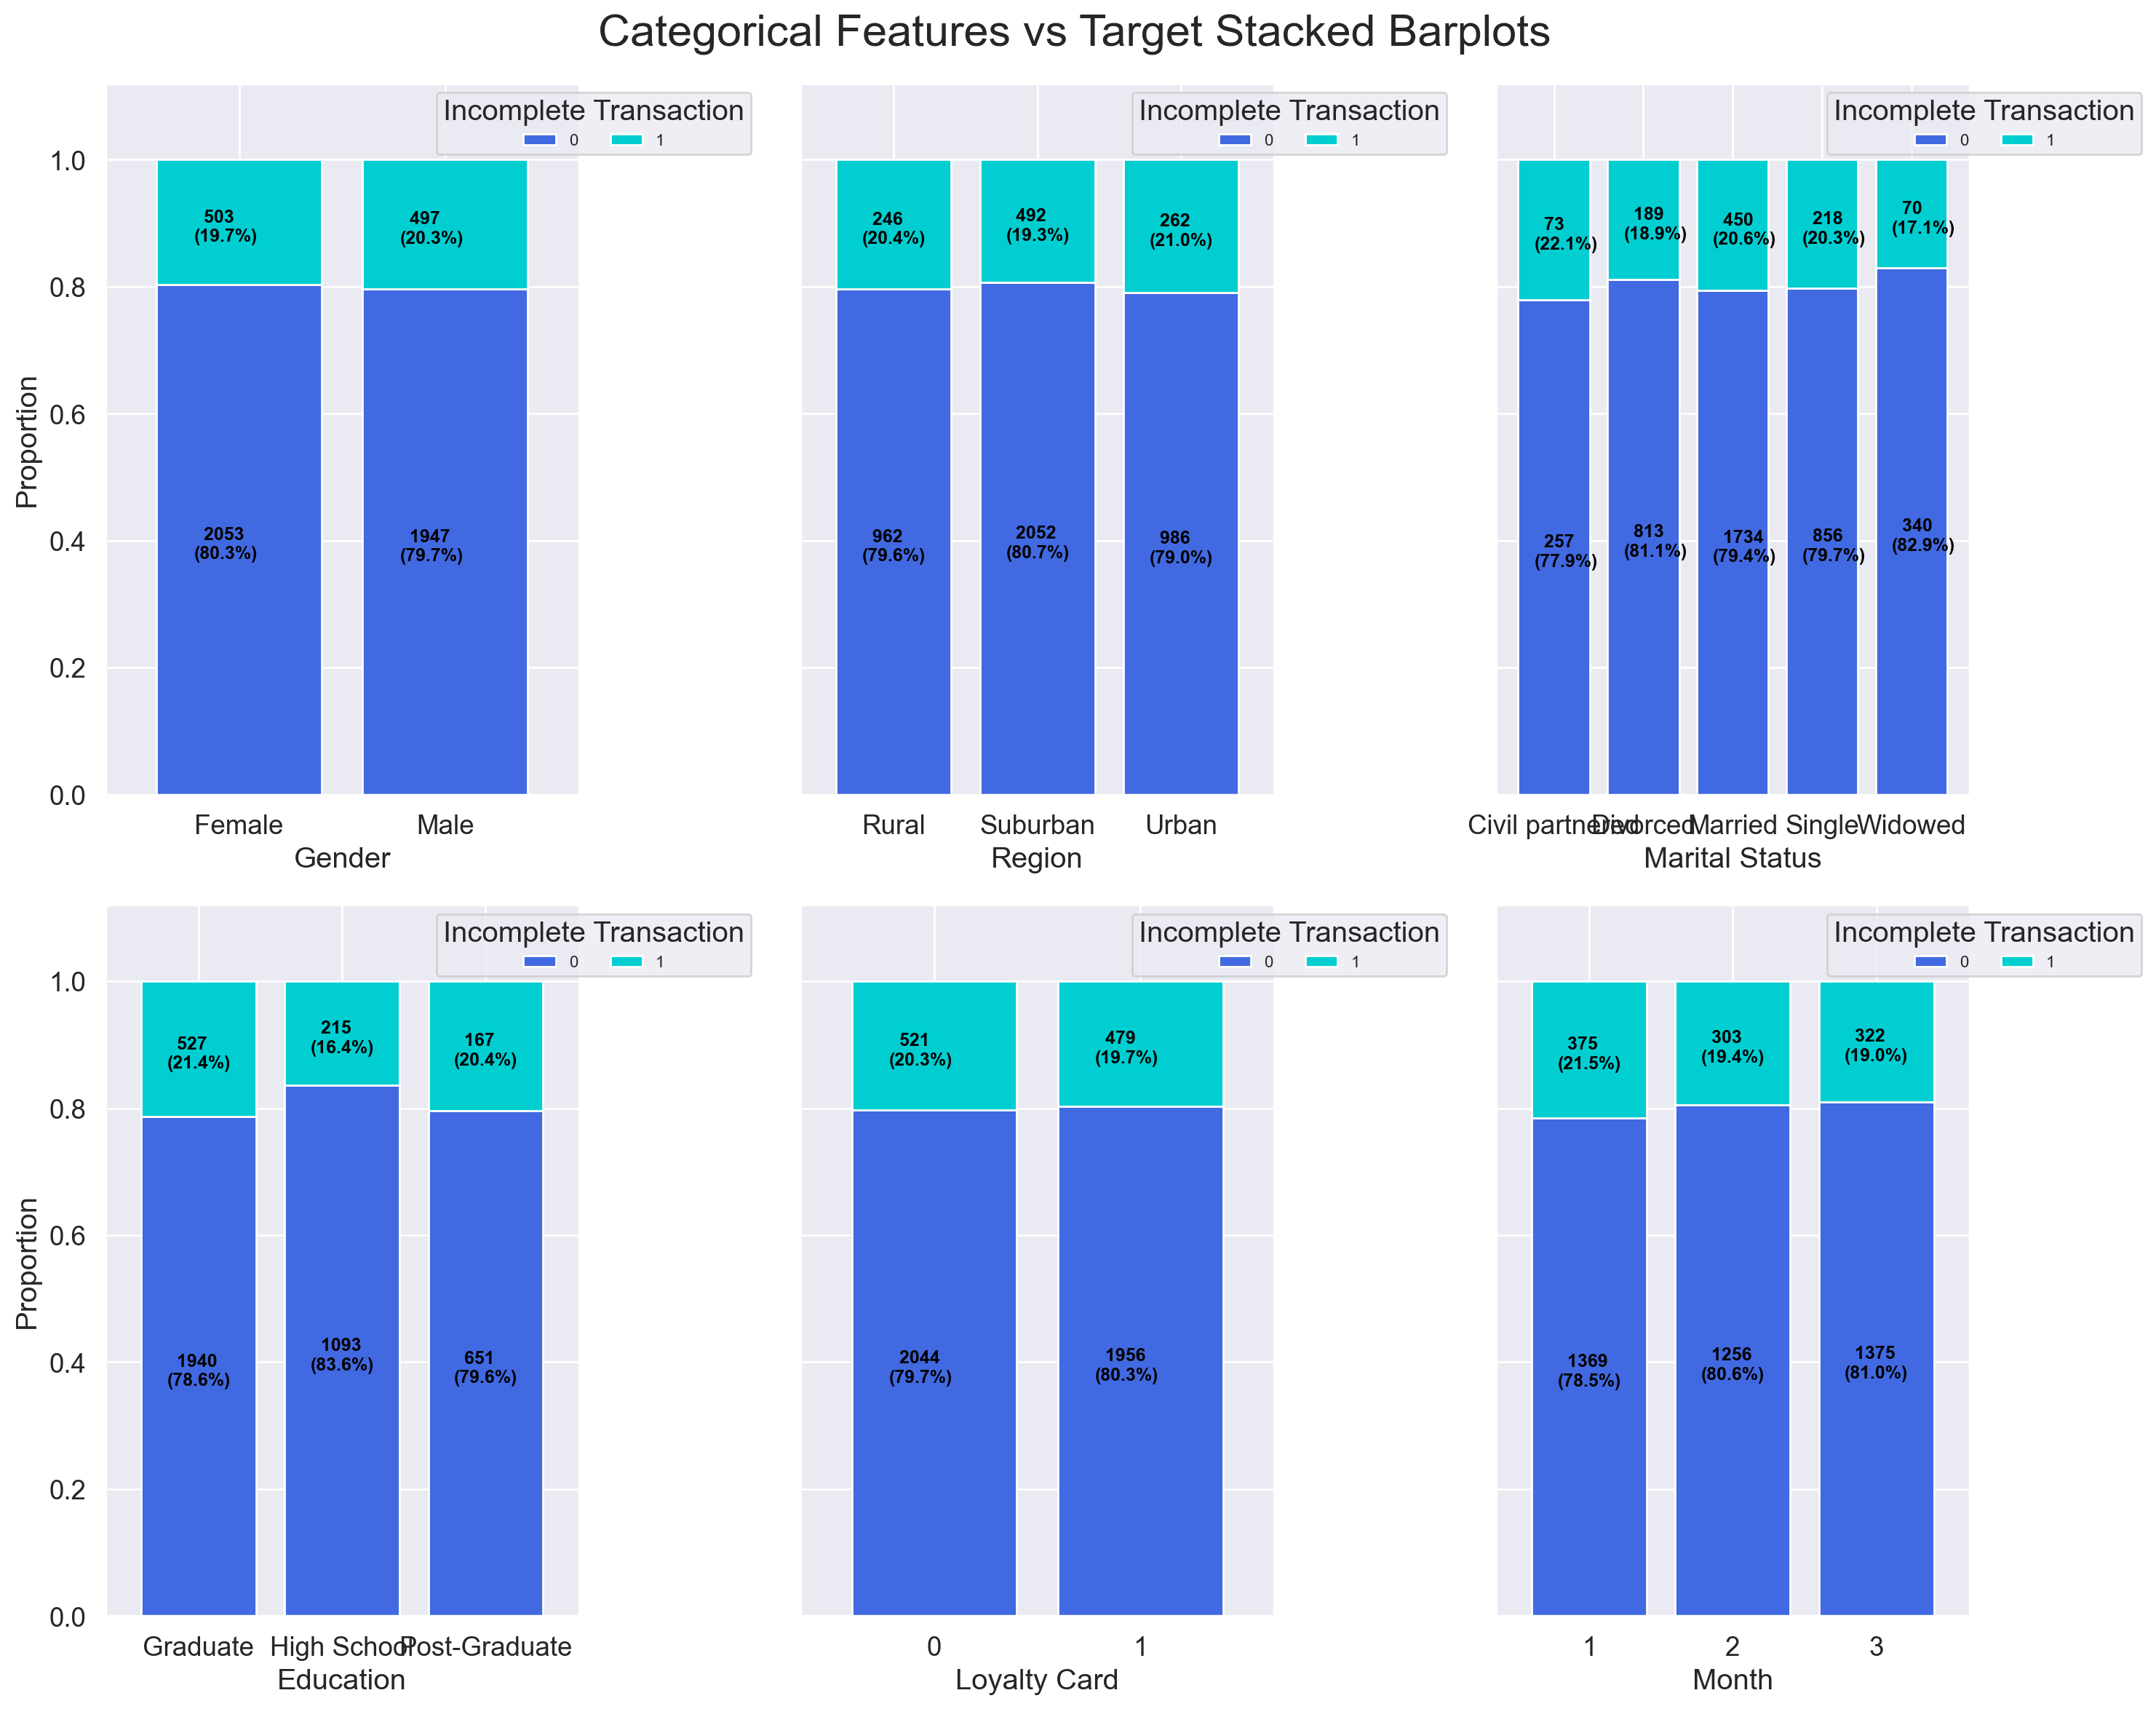

In [279]:
# Define a list containing the names of important categorical features in the dataset 
Cat_Features = ['Gender', 'Region', 'Marital Status', 'Education', 'Loyalty Card', 'Month']

# Define the target name in a variable for simplicity
Target = 'Incomplete Transaction'

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of complete and incomplete for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['royalblue', 'darkturquoise'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Incomplete Transaction', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
            

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

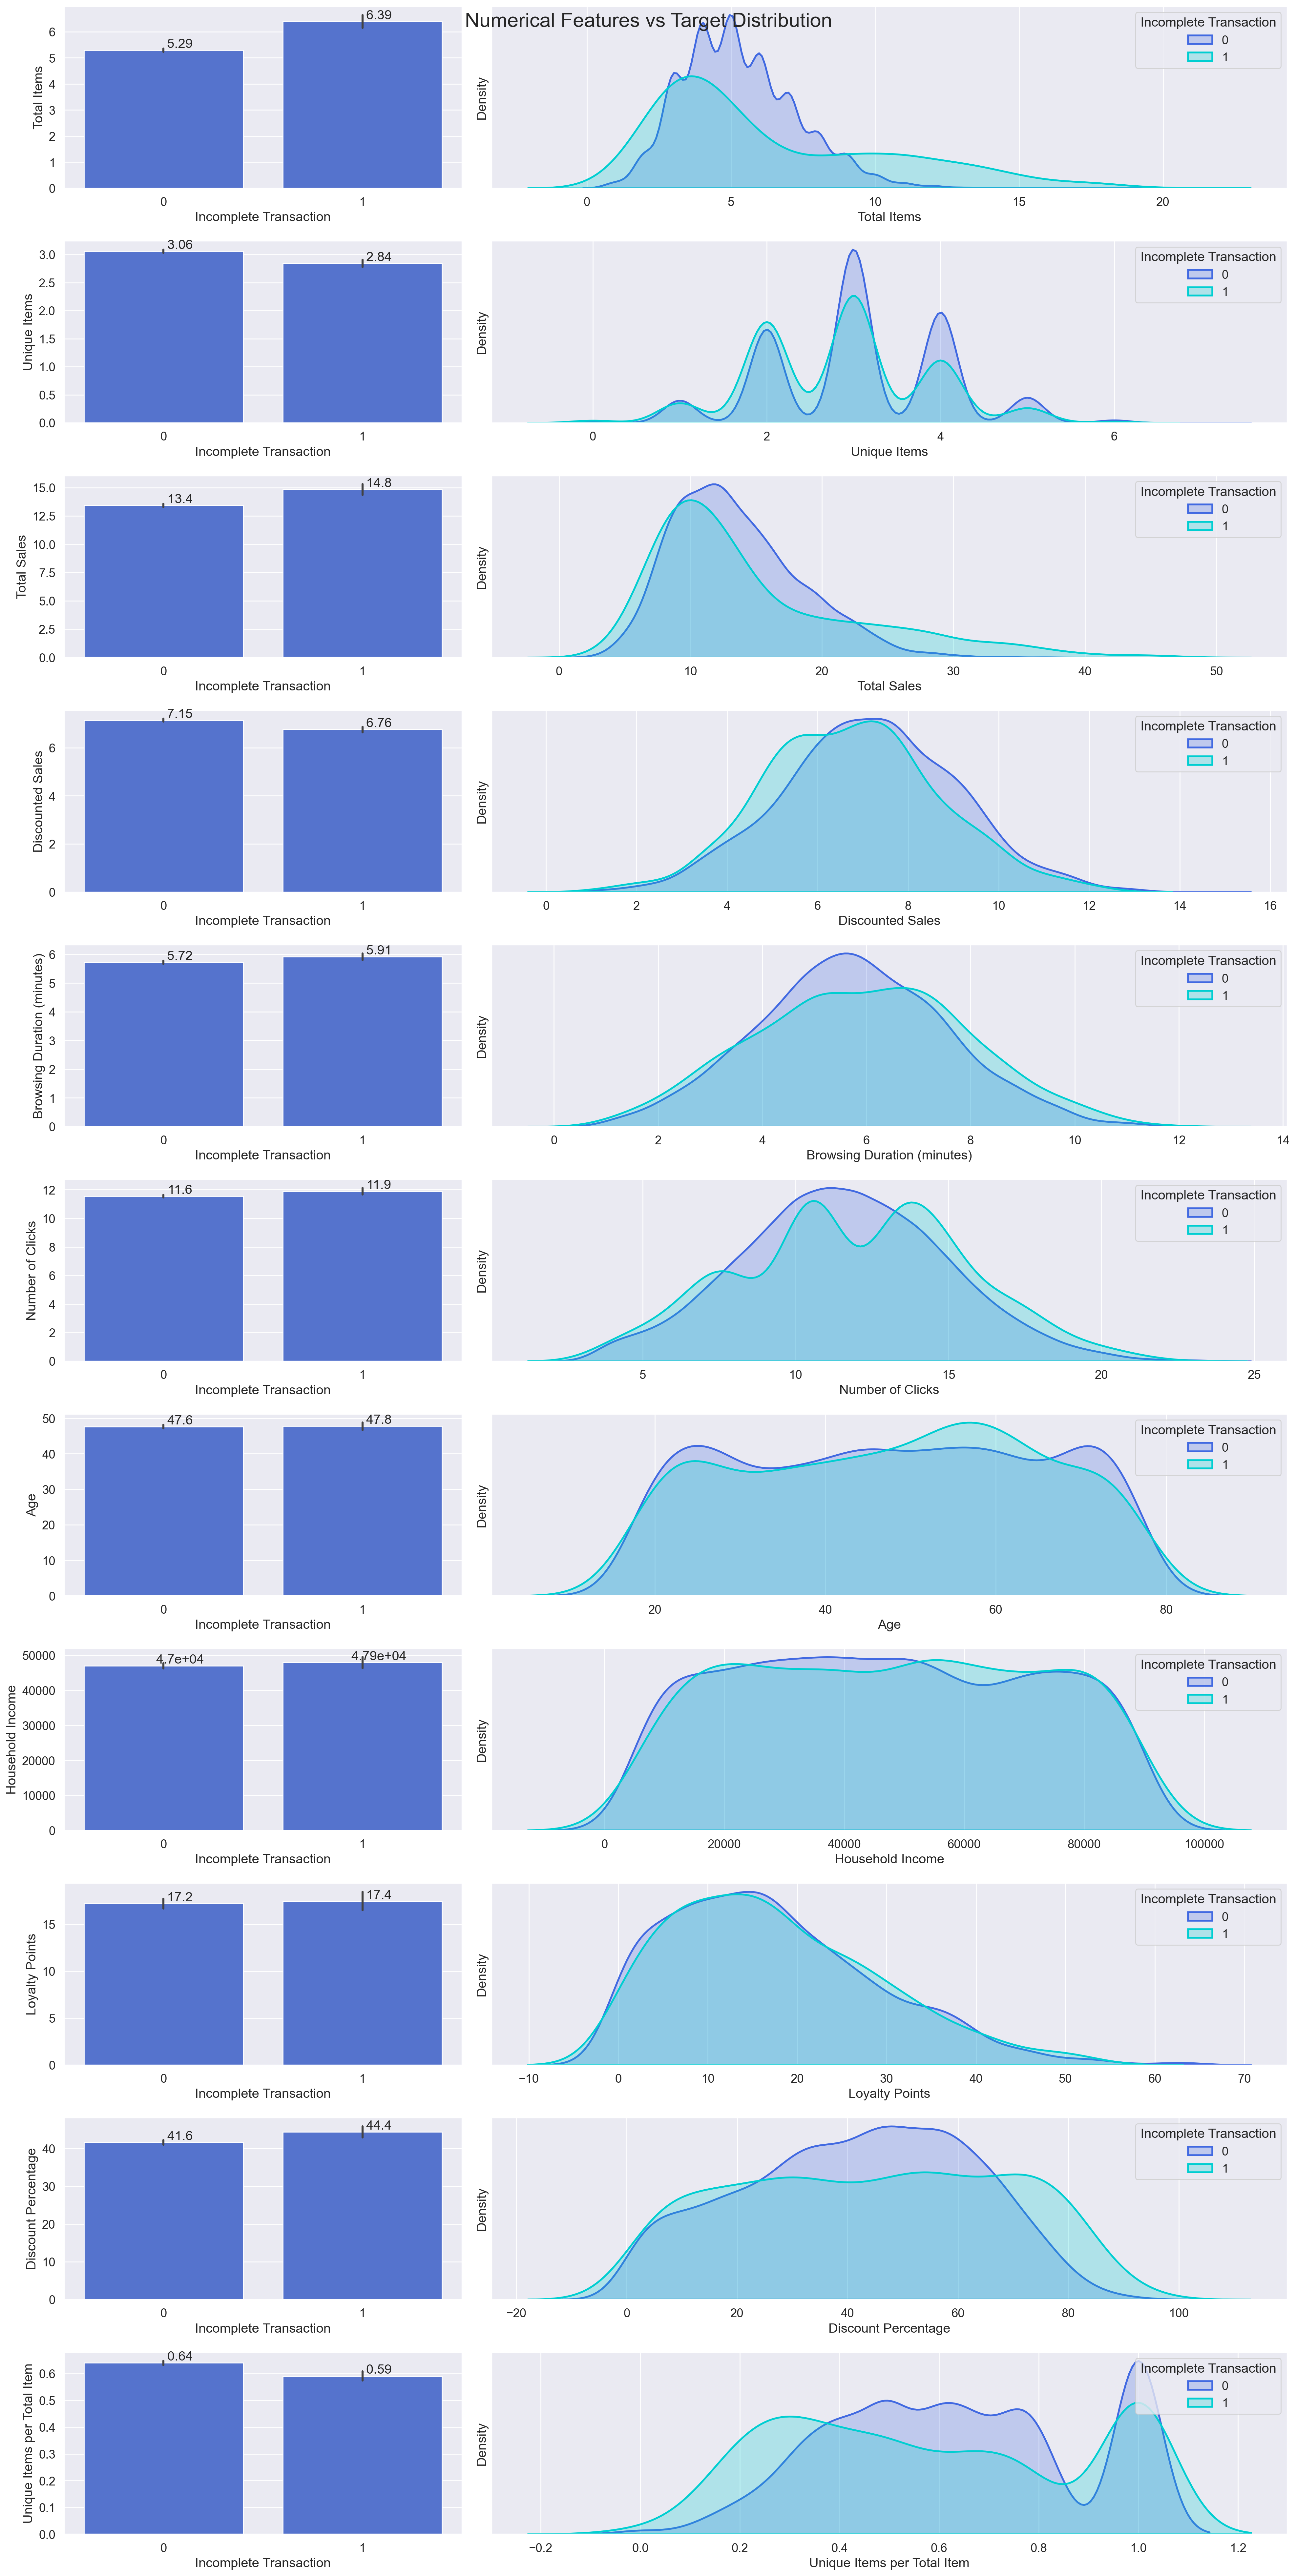

In [281]:
# Define a list containing the names of important numerical features in the dataset 
Num_Features = ['Total Items', 'Unique Items', 'Total Sales', 'Discounted Sales', 'Browsing Duration (minutes)', 'Number of Clicks', 'Age', 
                'Household Income', 'Loyalty Points', 'Discount Percentage', 'Unique Items per Total Item']


sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(11, 2, figsize=(20,40), dpi=200, gridspec_kw={'width_ratios': [1, 2]})


for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Incomplete Transaction', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

# Outliers 

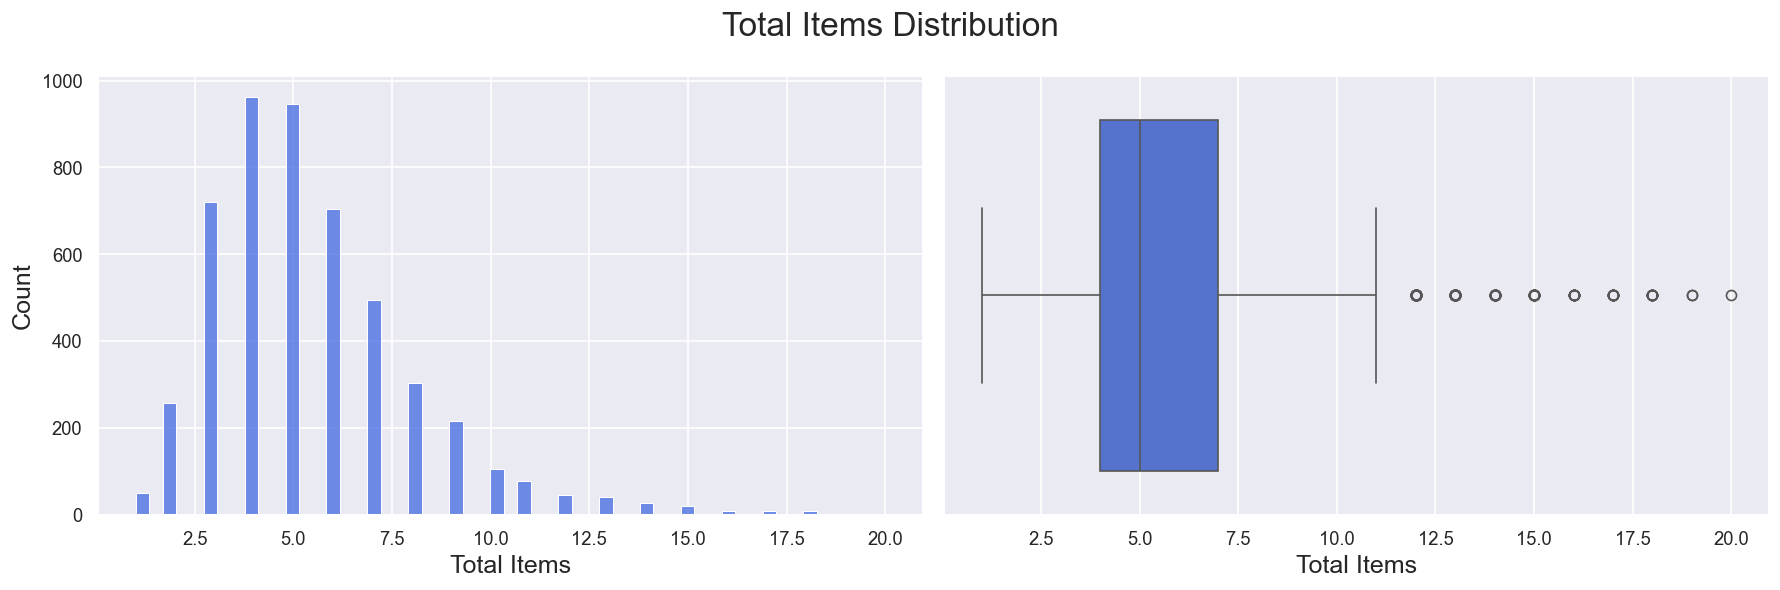

Outliers count in 'Total Items': 76


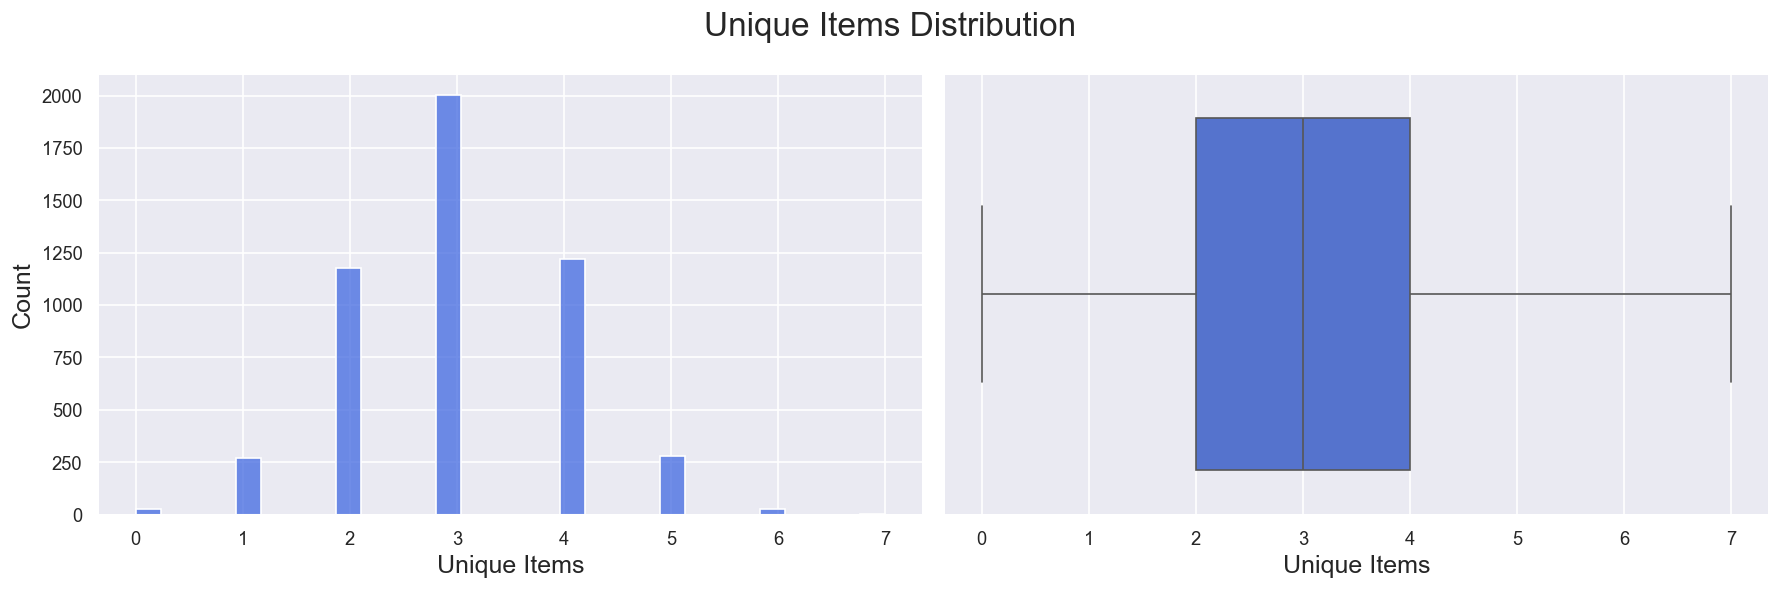

Outliers count in 'Unique Items': 1


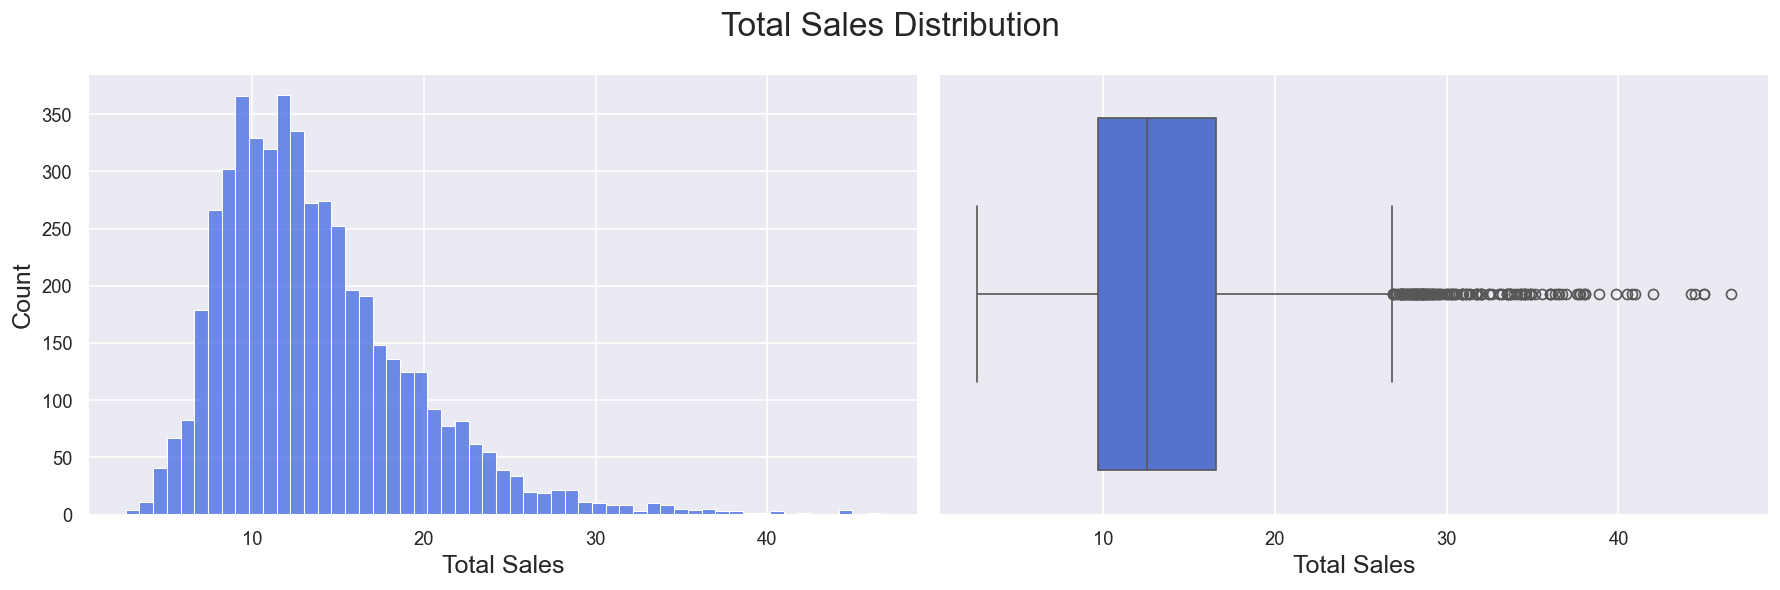

Outliers count in 'Total Sales': 68


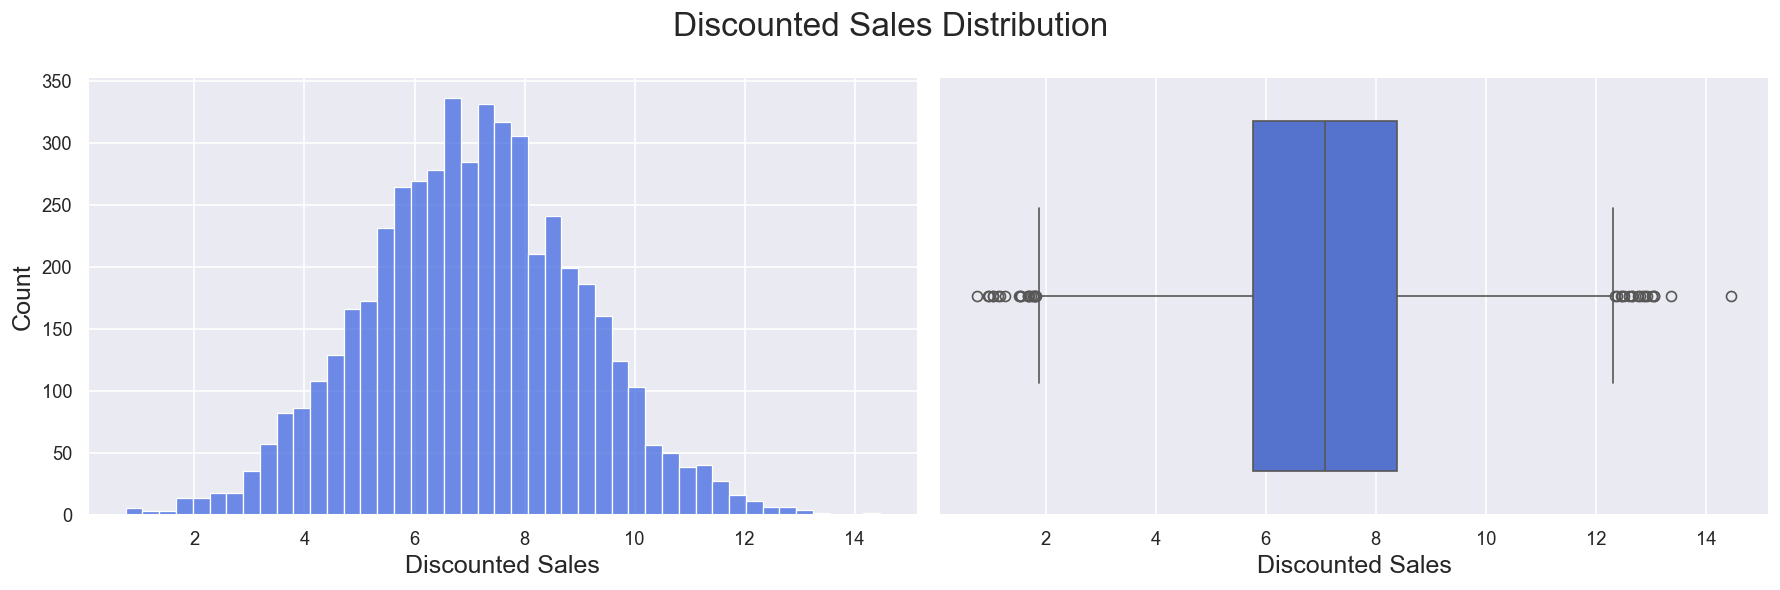

Outliers count in 'Discounted Sales': 6


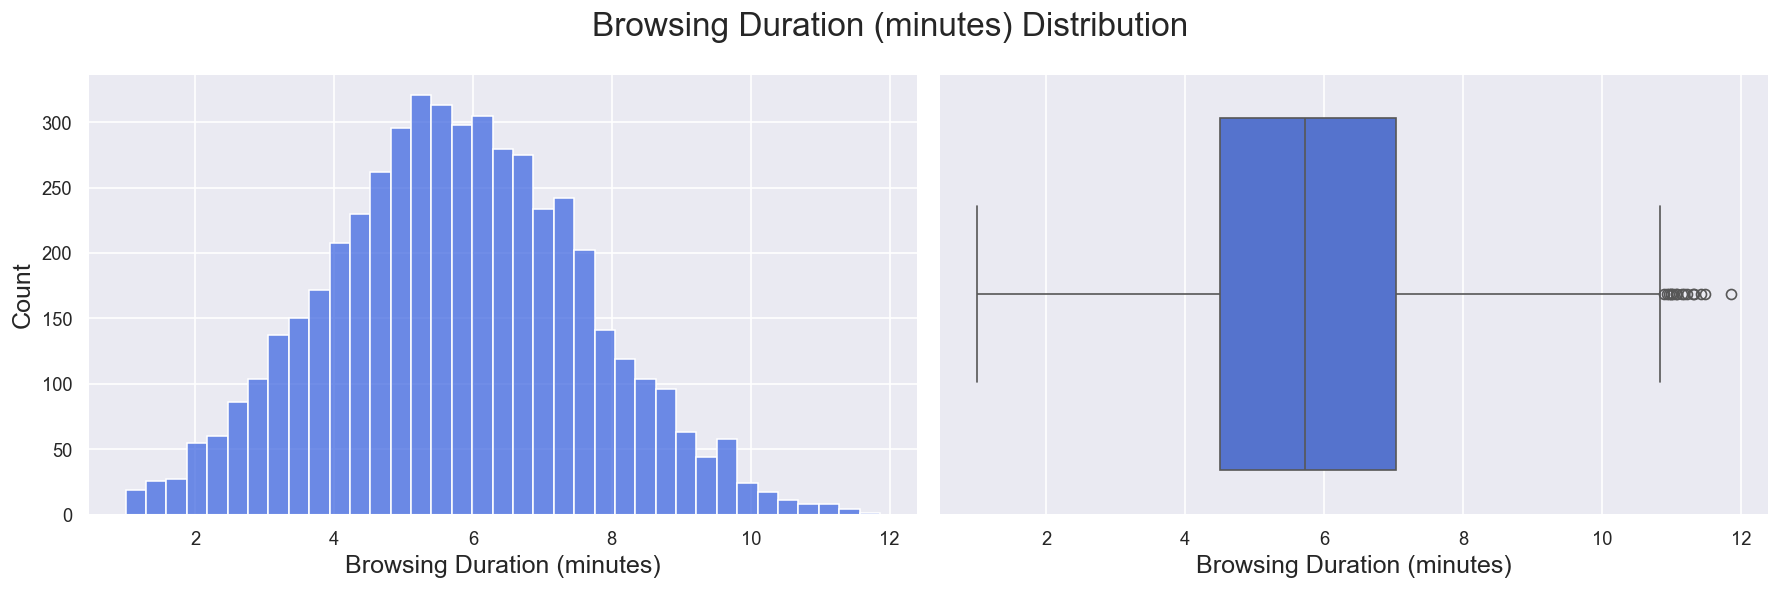

Outliers count in 'Browsing Duration (minutes)': 3


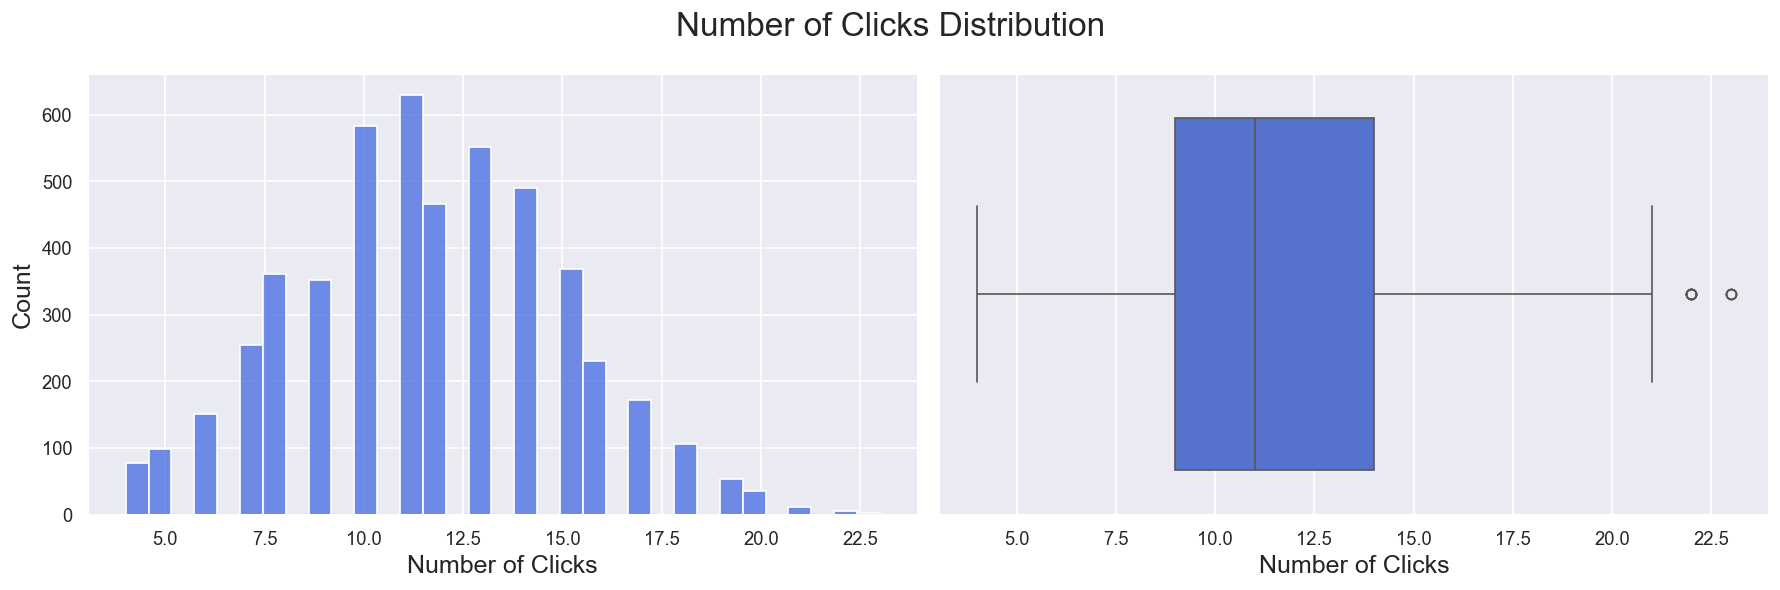

Outliers count in 'Number of Clicks': 8


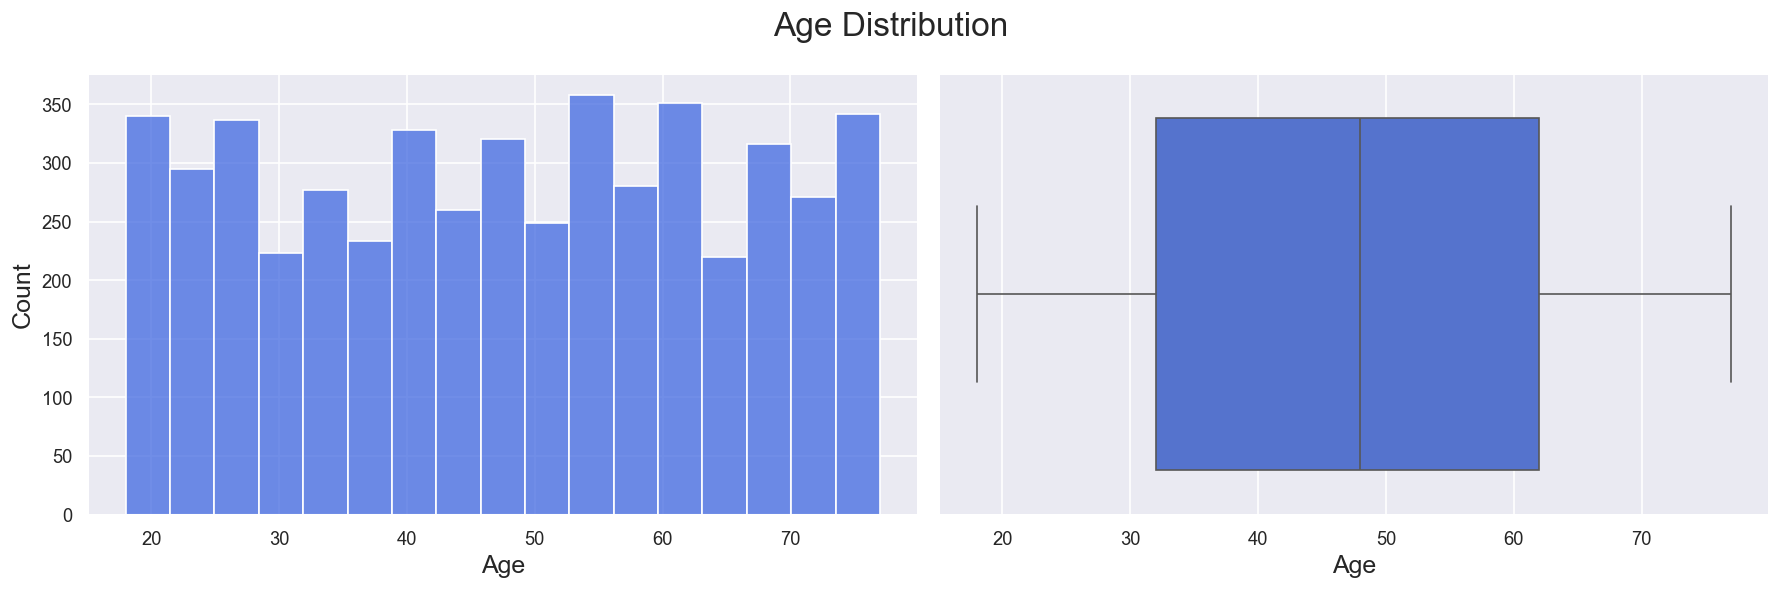

Outliers count in 'Age': 0


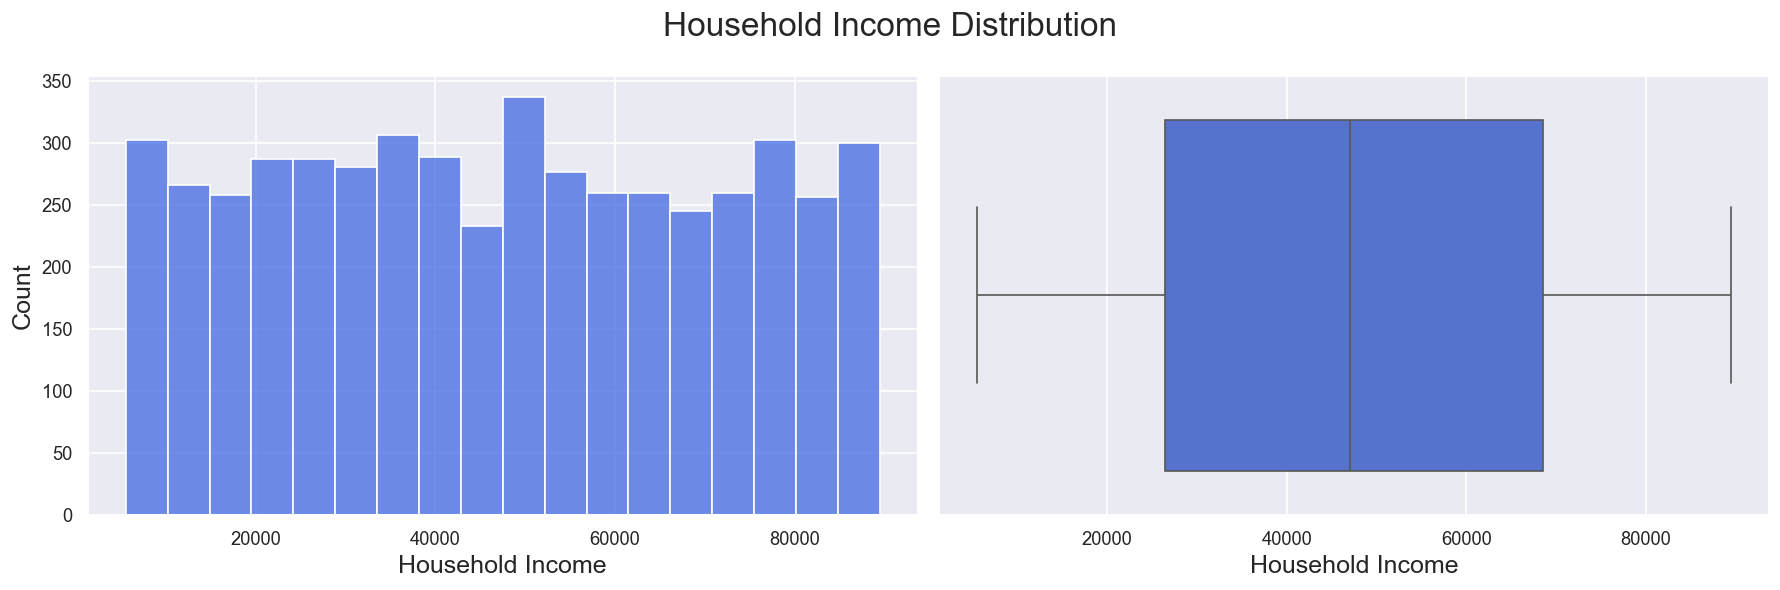

Outliers count in 'Household Income': 0


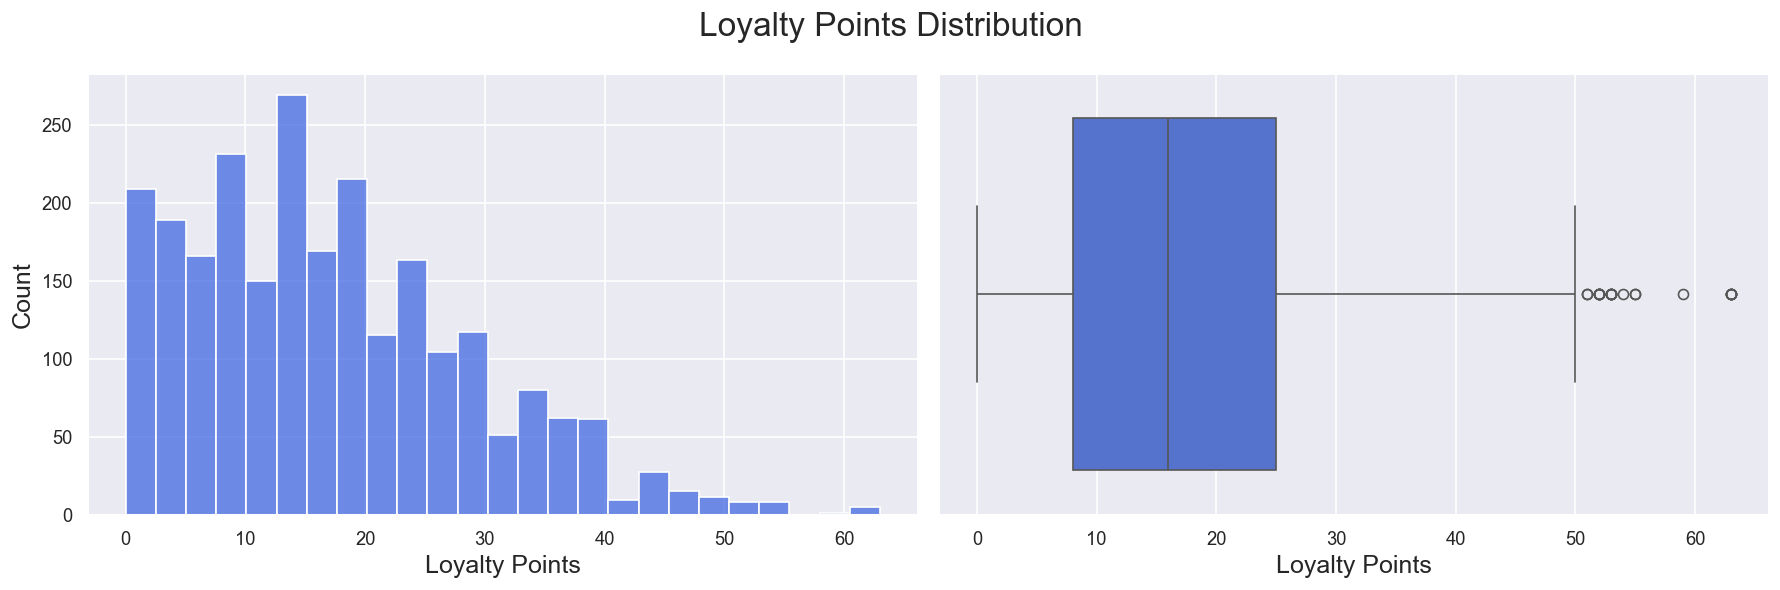

Outliers count in 'Loyalty Points': 0


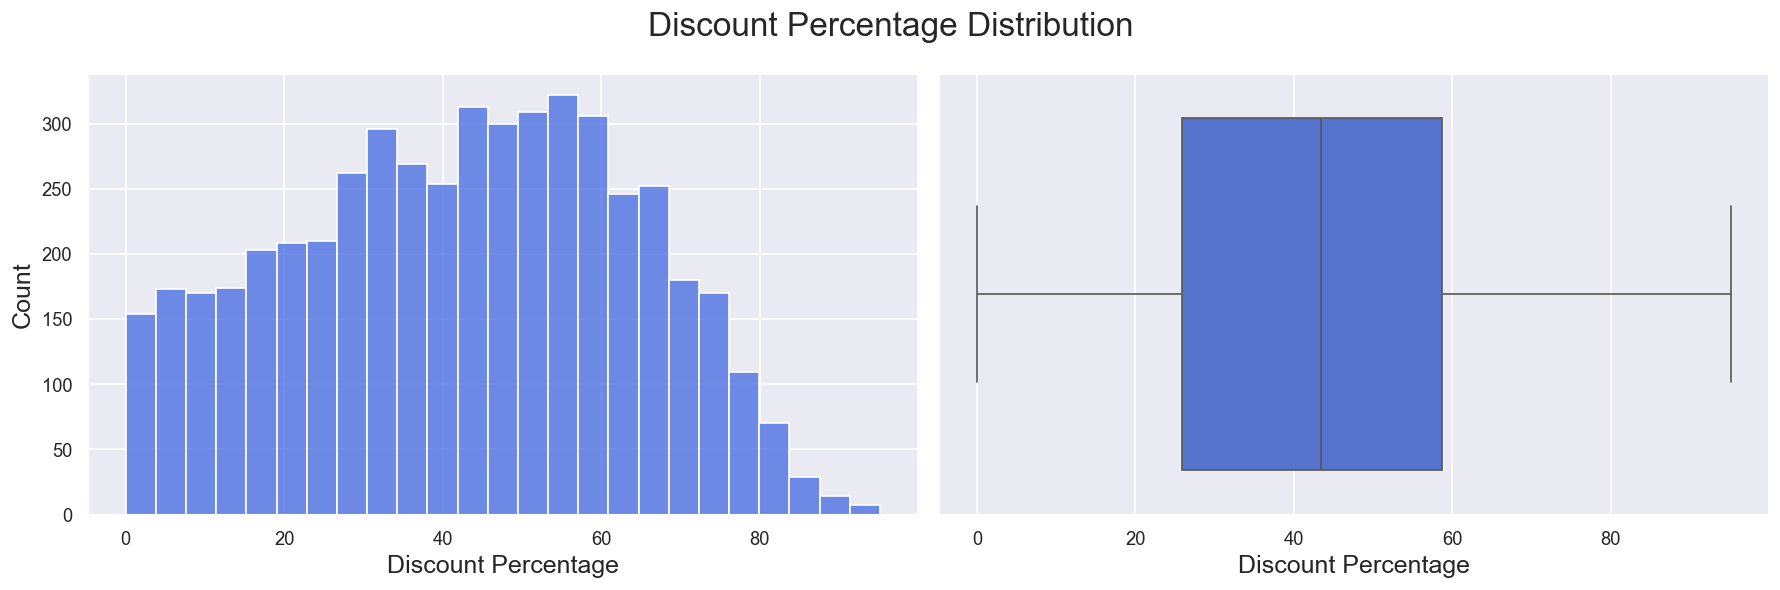

Outliers count in 'Discount Percentage': 0


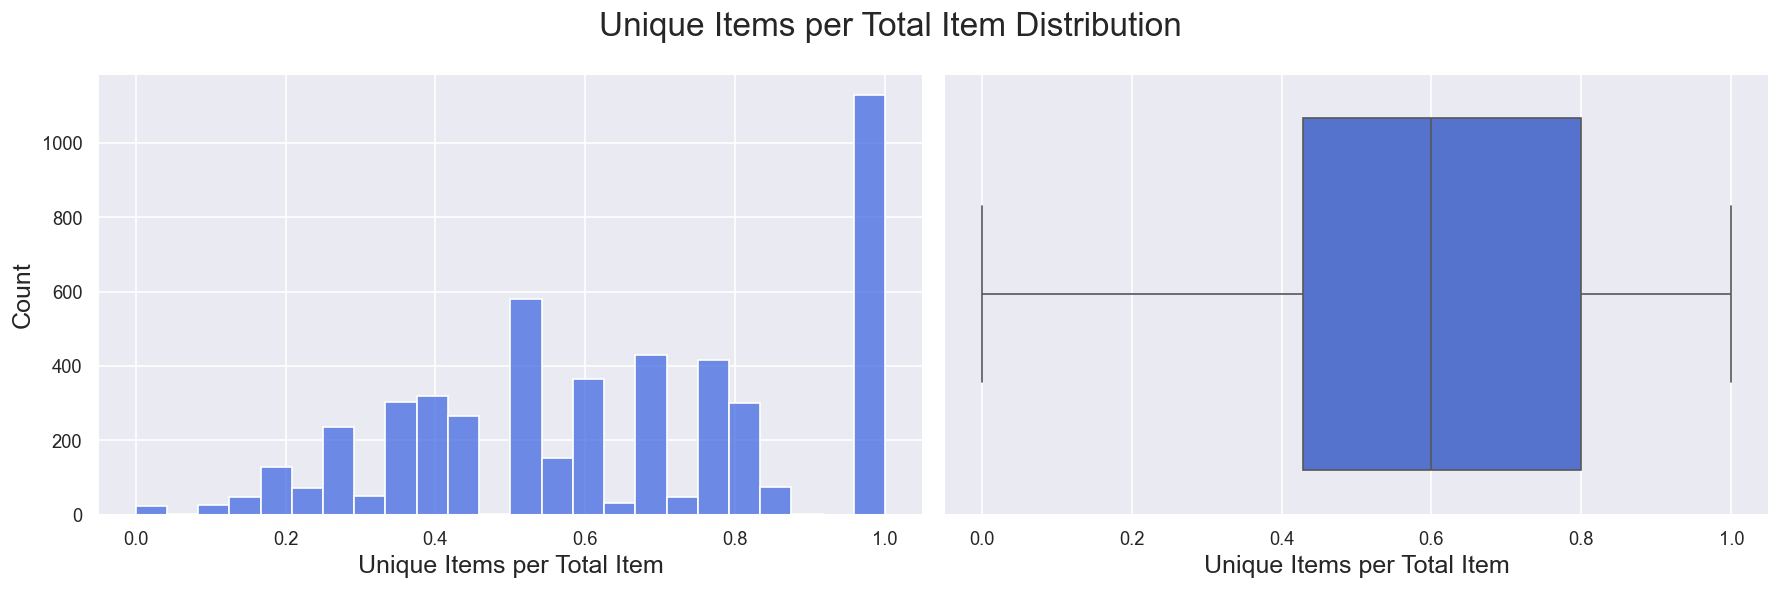

Outliers count in 'Unique Items per Total Item': 0


In [335]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming 'df' is your dataframe

Num_Features = ['Total Items', 'Unique Items', 'Total Sales', 'Discounted Sales', 'Browsing Duration (minutes)', 'Number of Clicks', 'Age', 
                'Household Income', 'Loyalty Points', 'Discount Percentage', 'Unique Items per Total Item']

# Set label size for axes
sns.set(rc={'axes.labelsize': 15})

# Iterate over each numerical column
for column in df[Num_Features].columns:
    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)
    
    # Histogram
    sns.histplot(x=column, data=df, color='royalblue', ax=ax[0])
    
    # Boxplot
    sns.boxplot(x=column, data=df, color='royalblue', ax=ax[1])
    
    # Title
    plt.suptitle(f'{column} Distribution', fontsize=20)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Outlier detection
    outliers_count = df[stats.zscore(df[column]) > 3][column].count()
    print(f"Outliers count in '{column}': {outliers_count}")


# TEST

from the above results, my main aim is to predict the customers that will possibly churn so they can be put in some sort of scheme to prevent churn hence the recall measures on the 1's is of more importance to me than the overall accuracy score of the model.
Given that in the data we only had 20% of churn, a recall greater than this baseline will already be an improvement but we want to get as high as possible while trying to maintain a high precision so that the bank can train its resources effectively towards clients highlighted by the model without wasting too much resources on the false positives.
From the review of the fitted models above, the best model that gives a decent balance of the recall and precision is the random forest where according to the fit on the training set, with a precision score on 1's of 0.88, out of all customers that the model thinks will churn, 88% do actually churn and with the recall score of 0.53 on the 1's, the model is able to highlight 53% of all those who churned.

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Total Items                  5000 non-null   int64  
 1   Unique Items                 5000 non-null   int64  
 2   Total Sales                  5000 non-null   float64
 3   Discounted Sales             5000 non-null   float64
 4   Browsing Duration (minutes)  5000 non-null   float64
 5   Number of Clicks             5000 non-null   int64  
 6   Incomplete Transaction       5000 non-null   int64  
 7   Age                          5000 non-null   int64  
 8   Gender                       5000 non-null   object 
 9   Region                       5000 non-null   object 
 10  Marital Status               5000 non-null   object 
 11  Education                    4593 non-null   object 
 12  Household Income             5000 non-null   float64
 13  Loyalty Card      

In [349]:
# Splitting X and y for all Experiments
X= df.drop('Incomplete Transaction', axis=1)
y = df['Incomplete Transaction']

In [351]:
# #test 

# feature_importances_list =['Total Items','Unique Items','Unique Items per Total Item','Total Sales']
# X = df[feature_importances_list]
# #X= df.drop('Incomplete Transaction', axis=1)

# y = df['Incomplete Transaction']
#X

## Split the data 

In [352]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((4000, 17), (1000, 17))

## preprocessing

In [303]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

# print columns
print('We have {} numerical features : {}'.format(len(num_features), num_features))
print('\nWe have {} categorical features : {}'.format(len(cat_features), cat_features))


# Define a pipeline for processing numeric features
numeric_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='mean')),
        ("scaler", StandardScaler())
    ]
)

# Define a pipeline for processing categorical features
categorical_processor = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy='most_frequent')),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
        
    ]
)

# Combine numeric and categorical processors
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numeric_processor, num_features), 
        ("categorical", categorical_processor, cat_features) 
    ]
)

We have 4 numerical features : Index(['Total Items', 'Unique Items', 'Unique Items per Total Item',
       'Total Sales'],
      dtype='object')

We have 0 categorical features : Index([], dtype='object')


In [304]:
# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

## model and parameters

In [65]:
# Define models
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoostClassifier": CatBoostClassifier(verbose=False),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "SVC": SVC()
}

models = {"XGBClassifier": XGBClassifier(), }




param_grids = {
    "RandomForestClassifier": {
        "randomforestclassifier__n_estimators": [100, 200, 300, 'default'],
        "randomforestclassifier__max_depth": [None, 10, 20, 'default'],
        "randomforestclassifier__min_samples_split": [2, 5, 10, 'default'],
        "randomforestclassifier__min_samples_leaf": [1, 2, 4, 'default'],
        "randomforestclassifier__bootstrap": [True, False, 'default']
    },
    "DecisionTreeClassifier": {
        "decisiontreeclassifier__max_depth": [None, 10, 20, 'default'],
        "decisiontreeclassifier__min_samples_split": [2, 5, 10, 'default'],
        "decisiontreeclassifier__min_samples_leaf": [1, 2, 4, 'default']
    },
    "GradientBoostingClassifier": {
        "gradientboostingclassifier__n_estimators": [100, 200, 300, 'default'],
        "gradientboostingclassifier__learning_rate": [0.05, 0.1, 0.2, 'default'],
        "gradientboostingclassifier__max_depth": [3, 5, 7, 'default'],
        "gradientboostingclassifier__min_samples_split": [2, 5, 10, 'default'],
        "gradientboostingclassifier__min_samples_leaf": [1, 2, 4, 'default']
    },
    "LogisticRegression": {
        "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 'default'],
        "logisticregression__penalty": ['l1', 'l2', 'default']
    },
    "KNeighborsClassifier": {
        "kneighborsclassifier__n_neighbors": [3, 5, 7, 9, 'default'],
        "kneighborsclassifier__weights": ['uniform', 'distance', 'default'],
        "kneighborsclassifier__metric": ['euclidean', 'manhattan', 'default']
    },
    "XGBClassifier": {
        "xgbclassifier__n_estimators": [100, 200, 300, 'default'],
        "xgbclassifier__max_depth": [3, 5, 7, 'default'],
        "xgbclassifier__learning_rate": [0.05, 0.1, 0.2, 'default'],
        "xgbclassifier__subsample": [0.6, 0.8, 1.0, 'default'],
        "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0, 'default'],
        "xgbclassifier__reg_alpha": [0, 0.001, 0.01, 0.1, 'default'],
        "xgbclassifier__reg_lambda": [0, 0.001, 0.01, 0.1, 'default']
    },
    "CatBoostClassifier": {
        "catboostclassifier__iterations": [100, 200, 300, 'default'],
        "catboostclassifier__learning_rate": [0.03, 0.1, 0.2, 'default'],
        "catboostclassifier__depth": [4, 6, 8, 'default'],
        "catboostclassifier__l2_leaf_reg": [1, 3, 5, 7, 9, 'default']
    },
    "AdaBoostClassifier": {
        "adaboostclassifier__n_estimators": [50, 100, 200, 'default'],
        "adaboostclassifier__learning_rate": [0.01, 0.05, 0.1, 0.2, 'default']
    },
    "SVC": {
        "svc__C": [0.1, 1, 10, 'default'],
        "svc__kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'default'],
        "svc__gamma": ['scale', 'auto', 'default']
    }
}




param_grids = {
    "RandomForestClassifier": {},
    "DecisionTreeClassifier": {},
    "GradientBoostingClassifier": {},
    "LogisticRegression": {},
    "KNeighborsClassifier": {},
    "XGBClassifier": {},
    "CatBoostClassifier": {},
    "AdaBoostClassifier": {},
    "SVC": {}

}

param_grids = {
    "XGBClassifier": {"xgbclassifier__n_estimators": [100, 200, 300, 'default'],
        "xgbclassifier__max_depth": [3, 5, 7, 'default'],
        "xgbclassifier__learning_rate": [0.001,0.01,0.05, 0.1, 'default'],
        "xgbclassifier__Scale_pos_weight":[1,2,4,5,10,20,'default']}

}

param_grids = {
    "XGBClassifier": {}

}

param_grids = {
    "XGBClassifier": {
        "xgbclassifier__n_estimators": [25,50,100, 200, 300, 'default'],
        "xgbclassifier__max_depth": [3,5,6,7, 'default'],
        "xgbclassifier__learning_rate": [0.001, 0.01, 0.05, 0.1,0.2,0.3, 'default'],
        "xgbclassifier__Scale_pos_weight": [4, 4*1.3, 4*1.5, 4*1.7,4*2.5, 4*3.5,'default'],
        "xgbclassifier__min_child_weight": [1, 5, 10],
        "xgbclassifier__subsample": [0.6, 0.8, 1.0],
        "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0],
        "xgbclassifier__colsample_bylevel": [0.6, 0.8, 1.0],
        "xgbclassifier__reg_alpha": [0, 0.1, 1],
        "xgbclassifier__reg_lambda": [0, 0.1, 1],
        "xgbclassifier__max_delta_step": [0, 1, 2],
        "xgbclassifier__gamma": [0, 0.1, 1],
        "xgbclassifier__max_leaf_nodes": [2, 4, 6]
    }
}


param_grids = {
    "XGBClassifier": {
        "n_estimators": [25,50,100, 200, 300, 'default'],
        "max_depth": [3,5,6,7, 'default'],
        "learning_rate": [0.001, 0.01, 0.05, 0.1,0.2,0.3, 'default'],
        "Scale_pos_weight": [4, 4*1.3, 4*1.5, 4*1.7,4*2.5, 4*3.5,'default'],
        "min_child_weight": [1, 5, 10],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "colsample_bylevel": [0.6, 0.8, 1.0],
        "reg_alpha": [0, 0.1, 1],
        "reg_lambda": [0, 0.1, 1],
        "max_delta_step": [0, 1, 2],
        "gamma": [0, 0.1, 1],
        "xmax_leaf_nodes": [2, 4, 6]
    }
}


In [56]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc


## Balanacing strategy

In [57]:
  # # Define the pipeline with SMOTE
    # pipe = ImbPipeline(
    # steps=[
    #     ("preprocessor", preprocessor),
    #     ("SMOTE", SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)),
    #     ("classifier", model)]
    # ) 

results = {}
save_models =False
output_directory =r"C:\Users\layeg\Desktop\GitHub\Holland_and_Barret\models"
kf = StratifiedKFold(n_splits=5, shuffle=False)


#scoring="roc_auc"
scoring=f1_metric

kf = StratifiedKFold(n_splits=5, shuffle=False)
#balancer = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
balancer = None 
#balancer = RandomUnderSampler(random_state=42)
#balancer =RandomOverSampler(random_state=42)
#balancer = SMOTE(random_state=42)

feature_names =X.columns

## Train models

In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def evaluate_models(models, X_train, y_train, X_test, y_test, preprocessor, balancer, param_grids,feature_names, kf, scoring, save_models=False, output_directory=None):
    results = {}

    for model_name, model in models.items():
        pipe = make_pipeline(preprocessor, balancer, model)

        # Perform grid search
        grid_search = GridSearchCV(pipe, param_grid =param_grids[model_name], cv=kf, scoring=scoring, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model and its hyperparameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Make predictions
        y_train_pred = best_model.predict(X_train)
        classifier_step_key = model_name.lower()
        print(best_model.named_steps.keys())
        # Apply ColumnTransformer to the test data
        X_test_transformed = best_model.named_steps['columntransformer'].transform(X_test)
        # Use the transformed test data to make predictions using the classifier step
        y_test_pred = best_model.named_steps[classifier_step_key].predict(X_test_transformed)
        #y_test_pred = best_model.named_steps['columntransformer',classifier_step_key].predict(X_test) # avoid data leakage and sampling on test set by only using classifier step 

        # Evaluate Train and Test dataset
        train_acc, train_f1 , train_precision, train_recall, train_roc_au = evaluate_clf(y_train, y_train_pred)
        test_acc, test_f1 , test_precision, test_recall, test_roc_au = evaluate_clf(y_test, y_test_pred)

        #store results in dictionary
        results[model_name] = {
            'Best Hyperparameters': best_params,
            'Best Score': best_score,
            'Train Accuracy': train_acc,
            'Train F1 Score': train_f1,
            'Train Precision': train_precision,
            'Train Recall': train_recall,
            'Train Roc Auc': train_roc_au,
            'Test Accuracy': test_acc,
            'Test F1 Score': test_f1,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test Roc Auc': test_roc_au
        }

        # Save the best model to the specified directory if specified
        if save_models and output_directory:
            current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_filename = f"{model_name.replace(' ', '_')}_{current_datetime}_best_model.joblib"
            model_filepath = os.path.join(output_directory, model_filename)
            joblib.dump(best_model, model_filepath)
            results[model_name]['Saved Model Filepath'] = model_filepath

                # For models that support feature importance or coefficients
        if hasattr(best_model.named_steps[classifier_step_key], 'feature_importances_'):
            results[model_name]['Feature Importances'] = dict(zip(feature_names, best_model.named_steps[classifier_step_key].feature_importances_))
        elif hasattr(best_model.named_steps[classifier_step_key], 'coef_'):
            results[model_name]['Coefficients'] = dict(zip(feature_names, best_model.named_steps[classifier_step_key].coef_))

    return results


In [39]:
results= evaluate_models(models, X_train, y_train, X_test, y_test, preprocessor=preprocessor, balancer=None, param_grids=param_grids,
                feature_names=feature_names, kf=kf, scoring=scoring, save_models=True, output_directory=output_directory)

dict_keys(['columntransformer', 'nonetype', 'xgbclassifier'])


In [66]:
#test without balancing 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def evaluate_models(models, X_train, y_train, X_test, y_test, param_grids,feature_names, kf, scoring, save_models=False, output_directory=None):
    results = {}

    for model_name, model in models.items():

        # Perform grid search
        grid_search = RandomizedSearchCV(model, param_distributions =param_grids[model_name], cv=kf, scoring=scoring, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model and its hyperparameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Make predictions
        y_train_pred = best_model.predict(X_train)
        # Apply ColumnTransformer to the test data
        # Use the transformed test data to make predictions using the classifier step
        y_test_pred = best_model.predict(X_test)
        #y_test_pred = best_model.named_steps['columntransformer',classifier_step_key].predict(X_test) # avoid data leakage and sampling on test set by only using classifier step 

        # Evaluate Train and Test dataset
        train_acc, train_f1 , train_precision, train_recall, train_roc_au = evaluate_clf(y_train, y_train_pred)
        test_acc, test_f1 , test_precision, test_recall, test_roc_au = evaluate_clf(y_test, y_test_pred)

        #store results in dictionary
        results[model_name] = {
            'Best Hyperparameters': best_params,
            'Best Score': best_score,
            'Train Accuracy': train_acc,
            'Train F1 Score': train_f1,
            'Train Precision': train_precision,
            'Train Recall': train_recall,
            'Train Roc Auc': train_roc_au,
            'Test Accuracy': test_acc,
            'Test F1 Score': test_f1,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test Roc Auc': test_roc_au
        }


    return results, best_model


#### Experiment 1
- scoring = roc_auc
- kf = StratifiedKFold(n_splits=5, shuffle=False)
- featrures = all 17 features 
- imputer_numeric = SimpleImputer(strategy='mean') , categorical_imputer = SimpleImputer(strategy='most_frequent') 
- numeric_scaler = StandardScaler(), categorical_scaler = OneHotEncoder()
- hyperparameters = defualt, GridSearchCV
- balancer = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)


In [ ]:
# each model is a row and each metric is a column
df_results_SMOTETomek = pd.DataFrame.from_dict(results, orient='index')
df_results_SMOTETomek_sorted = df_results_SMOTETomek.sort_values(by='Best Score', ascending=False)
df_results_SMOTETomek

,Best Hyperparameters,Best Score,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Train Roc Auc,Test Accuracy,Test F1 Score,Test Precision,Test Recall,Test Roc Auc
RandomForestClassifier,{},0.766337,0.99825,0.995617,0.997491,0.99375,0.996562,0.845,0.488449,0.718447,0.370,0.666875
DecisionTreeClassifier,{},0.649219,0.99825,0.995628,0.995006,0.99625,0.997500,0.754,0.435780,0.402542,0.475,0.649375
GradientBoostingClassifier,{},0.807949,0.86175,0.560064,0.770241,0.44000,0.703594,0.851,0.508251,0.747573,0.385,0.676250
LogisticRegression,{},0.731437,0.71000,0.464945,0.368421,0.63000,0.680000,0.720,0.467681,0.377301,0.615,0.680625
KNeighborsClassifier,{},0.691601,0.79200,0.649241,0.489822,0.96250,0.855938,0.664,0.432432,0.326531,0.640,0.655000
XGBClassifier,{},0.790334,0.99300,0.982211,0.998708,0.96625,0.982969,0.832,0.464968,0.640351,0.365,0.656875
CatBoostClassifier,{},0.808916,0.93450,0.810694,0.960616,0.70125,0.847031,0.850,0.519231,0.723214,0.405,0.683125
AdaBoostClassifier,{},0.761268,0.81175,0.482474,0.535878,0.43875,0.671875,0.810,0.460227,0.532895,0.405,0.658125
SVC,{},0.750691,0.85600,0.690655,0.605461,0.80375,0.836406,0.776,0.479070,0.447826,0.515,0.678125


#### Experiment 2
- scoring = roc_auc
- kf = StratifiedKFold(n_splits=5, shuffle=False)
- featrures = all 17 features 
- imputer_numeric = SimpleImputer(strategy='mean') , categorical_imputer = SimpleImputer(strategy='most_frequent') 
- numeric_scaler = StandardScaler(), categorical_scaler = OneHotEncoder()
- hyperparameters = defualt, GridSearchCV
- balancer = RandomUnderSampler(random_state=42)

In [ ]:
# each model is a row and each metric is a column
df_results_RandomUnderSampler = pd.DataFrame.from_dict(results, orient='index')
df_results_RandomUnderSampler_sorted = df_results_RandomUnderSampler.sort_values(by='Best Score', ascending=False)
df_results_RandomUnderSampler_sorted

,Best Hyperparameters,Best Score,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Train Roc Auc,Test Accuracy,Test F1 Score,Test Precision,Test Recall,Test Roc Auc
CatBoostClassifier,{},0.813012,0.81725,0.671165,0.524245,0.93250,0.860469,0.776,0.569231,0.462500,0.740,0.762500
GradientBoostingClassifier,{},0.806408,0.78725,0.604738,0.481153,0.81375,0.797187,0.768,0.550388,0.449367,0.710,0.746250
AdaBoostClassifier,{},0.794926,0.76025,0.540489,0.438228,0.70500,0.739531,0.776,0.537190,0.457746,0.650,0.728750
XGBClassifier,{},0.782963,0.81975,0.689358,0.525970,1.00000,0.887344,0.736,0.525180,0.410112,0.730,0.733750
RandomForestClassifier,{},0.773471,0.84300,0.718133,0.560224,1.00000,0.901875,0.755,0.529750,0.429907,0.690,0.730625
SVC,{},0.756762,0.75950,0.555453,0.440616,0.75125,0.756406,0.753,0.518519,0.424920,0.665,0.720000
LogisticRegression,{},0.727854,0.69950,0.453139,0.356223,0.62250,0.670625,0.736,0.501887,0.403030,0.665,0.709375
KNeighborsClassifier,{},0.696781,0.74250,0.543440,0.421016,0.76625,0.751406,0.698,0.446886,0.352601,0.610,0.665000
DecisionTreeClassifier,{},0.649844,0.77600,0.641026,0.471698,1.00000,0.860000,0.666,0.443333,0.332500,0.665,0.665625


#### Experiment 3
- scoring = roc_auc
- kf = StratifiedKFold(n_splits=5, shuffle=False)
- featrures = all 17 features 
- imputer_numeric = SimpleImputer(strategy='mean') , categorical_imputer = SimpleImputer(strategy='most_frequent') 
- numeric_scaler = StandardScaler(), categorical_scaler = OneHotEncoder()
- hyperparameters = defualt, GridSearchCV
- balancer = RandomOverSampler(random_state=42)

In [ ]:
# each model is a row and each metric is a column
df_results_RandomOverSampler = pd.DataFrame.from_dict(results, orient='index')
df_results_RandomOverSampler_sorted = df_results_RandomOverSampler.sort_values(by='Best Score', ascending=False)
df_results_RandomOverSampler_sorted


,Best Hyperparameters,Best Score,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Train Roc Auc,Test Accuracy,Test F1 Score,Test Precision,Test Recall,Test Roc Auc
GradientBoostingClassifier,{},0.809158,0.81725,0.633584,0.528870,0.79000,0.807031,0.792,0.570248,0.485915,0.690,0.753750
CatBoostClassifier,{},0.809070,0.95525,0.894520,0.846154,0.94875,0.952813,0.843,0.590078,0.617486,0.565,0.738750
AdaBoostClassifier,{},0.796908,0.77175,0.543272,0.452877,0.67875,0.736875,0.794,0.563559,0.488971,0.665,0.745625
RandomForestClassifier,{},0.786044,1.00000,1.000000,1.000000,1.00000,1.000000,0.840,0.473684,0.692308,0.360,0.660000
XGBClassifier,{},0.779600,0.99625,0.990631,0.990012,0.99125,0.994375,0.816,0.494505,0.548780,0.450,0.678750
SVC,{},0.765615,0.84150,0.668063,0.574775,0.79750,0.825000,0.775,0.507659,0.451362,0.580,0.701875
LogisticRegression,{},0.731408,0.71525,0.468502,0.373790,0.62750,0.682344,0.738,0.490272,0.401274,0.630,0.697500
KNeighborsClassifier,{},0.670538,0.81000,0.657349,0.514104,0.91125,0.847969,0.680,0.422383,0.330508,0.585,0.644375
DecisionTreeClassifier,{},0.604688,1.00000,1.000000,1.000000,1.00000,1.000000,0.772,0.415385,0.426316,0.405,0.634375


#### Experiment 4
- scoring = roc_auc
- kf = StratifiedKFold(n_splits=5, shuffle=False)
- featrures = all 17 features 
- imputer_numeric = SimpleImputer(strategy='mean') , categorical_imputer = SimpleImputer(strategy='most_frequent') 
- numeric_scaler = StandardScaler(), categorical_scaler = OneHotEncoder()
- hyperparameters = defualt, GridSearchCV
- balancer = SMOTE(random_state=42)

In [ ]:
# each model is a row and each metric is a column
df_results_SMOTE = pd.DataFrame.from_dict(results, orient='index')
df_results_SMOTE_sorted = df_results_SMOTE.sort_values(by='Best Score', ascending=False)
df_results_SMOTE_sorted

,Best Hyperparameters,Best Score,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Train Roc Auc,Test Accuracy,Test F1 Score,Test Precision,Test Recall,Test Roc Auc
CatBoostClassifier,{},0.813678,0.93875,0.824121,0.967960,0.71750,0.855781,0.846,0.506410,0.705357,0.395,0.676875
GradientBoostingClassifier,{},0.806887,0.85850,0.545746,0.762332,0.42500,0.695937,0.850,0.496644,0.755102,0.370,0.670000
XGBClassifier,{},0.782920,0.99375,0.984127,1.000000,0.96875,0.984375,0.830,0.462025,0.629310,0.365,0.655625
RandomForestClassifier,{},0.770078,1.00000,1.000000,1.000000,1.00000,1.000000,0.848,0.506494,0.722222,0.390,0.676250
AdaBoostClassifier,{},0.757950,0.81175,0.481762,0.535988,0.43750,0.671406,0.810,0.460227,0.532895,0.405,0.658125
SVC,{},0.751215,0.85650,0.691398,0.606604,0.80375,0.836719,0.775,0.475524,0.445415,0.510,0.675625
LogisticRegression,{},0.731318,0.71050,0.464880,0.368768,0.62875,0.679844,0.721,0.468571,0.378462,0.615,0.681250
KNeighborsClassifier,{},0.692366,0.79300,0.651222,0.491105,0.96625,0.857969,0.664,0.432432,0.326531,0.640,0.655000
DecisionTreeClassifier,{},0.647188,1.00000,1.000000,1.000000,1.00000,1.000000,0.758,0.439815,0.409483,0.475,0.651875


In [ ]:
import pandas as pd

# Assuming df_results_SMOTETomek, df_results_RandomUnderSampler, df_results_RandomOverSampler, df_results_SMOTE are your dataframes

# Combine dataframes
combined_df = pd.concat([df_results_SMOTETomek, df_results_RandomUnderSampler, df_results_RandomOverSampler, df_results_SMOTE], axis=0)

# Optionally, you can add a 'Balancer' column to identify which balancer was used for each row
combined_df['Balancer'] = ['SMOTETomek'] * len(df_results_SMOTETomek) + ['RandomUnderSampler'] * len(df_results_RandomUnderSampler) + ['RandomOverSampler'] * len(df_results_RandomOverSampler) + ['SMOTE'] * len(df_results_SMOTE)



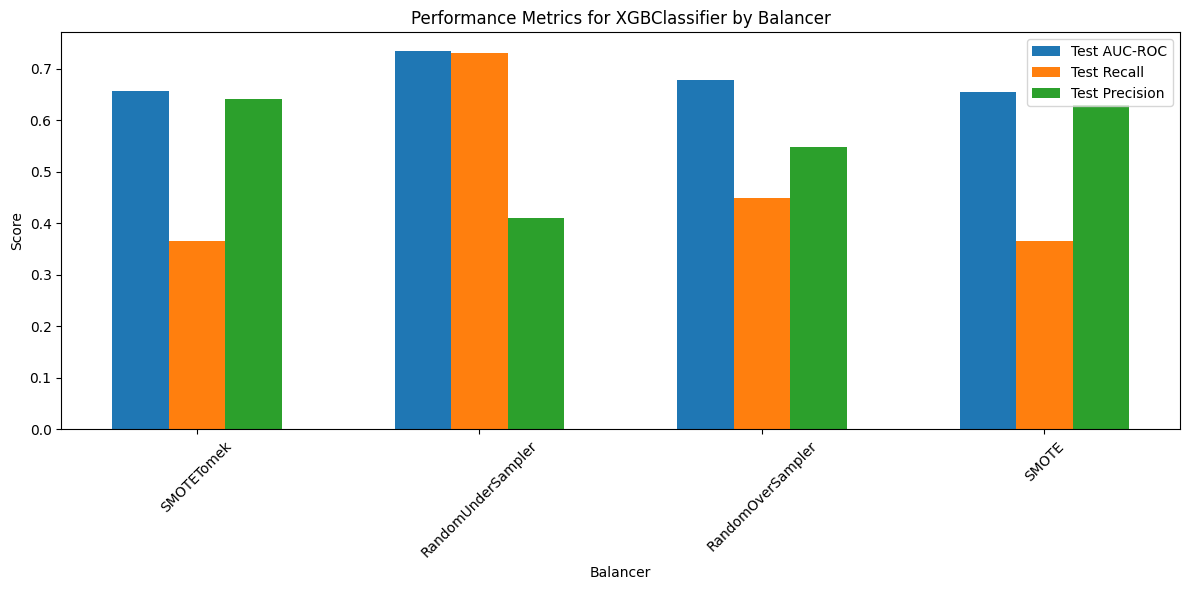

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter rows for SVC classifier
svc_df = combined_df[combined_df.index == 'XGBClassifier']

# Get unique balancer options
balancers = svc_df['Balancer'].unique()

# Define width for each bar
bar_width = 0.2

# Set up figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot test AUC-ROC, recall, and precision for different balancer options
index = np.arange(len(balancers))
bar1 = ax.bar(index - bar_width, svc_df['Test Roc Auc'], bar_width, label='Test AUC-ROC')
bar2 = ax.bar(index, svc_df['Test Recall'], bar_width, label='Test Recall')
bar3 = ax.bar(index + bar_width, svc_df['Test Precision'], bar_width, label='Test Precision')

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(balancers, rotation=45)

# Add labels, title, and legend
ax.set_xlabel('Balancer')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics for XGBClassifier by Balancer')
ax.legend()

plt.tight_layout()
plt.show()


# modular code 

# Code Explanation
- setup.py is resposible for creating ML application as a python package and depoloying in the pypi 
- tutorial 4 . 17:00
- in data_ingestion testdf and traindf is not used stratified split but i checked the distribution is almost correct in th test df (799,201). maybe it is better to change that so not book be the same.
- till now we are implementing 
- till end of hyperparameter tuning episod 7
- we need to implemet tran pipeline. look at the code on the dowloads file. the train pipe line seems easy if you donot want to run it on the cloud.
- predic pipeline we can use the krish tutorial 
- by runnig data ingestion , the code runes and we can train the models. the only thing is to we are preprocessing the train dataset in the data tarnsformation which coul messed with the grid search becuase daat leakage to cv.
- ml flow https://www.youtube.com/watch?v=pxk1Fr33-L4&list=PLZoTAELRMXVPS-dOaVbAux22vzqdgoGhG&index=22

In [ ]:
#read df 
df = pd.read_csv(r"C:\Users\layeg\Desktop\GitHub\Holland_and_Barret\artifacts\test.csv")

In [ ]:
df['Incomplete Transaction'].value_counts()

Incomplete Transaction
0    799
1    201
Name: count, dtype: int64

- cost senstive svm is not improving . even after balancing having a weight 

# kaggle

In [46]:

# Convert training and test sets from numpy array to pandas dataframes
# X_train = pd.DataFrame(X_train, columns=X.columns)
# X_test = pd.DataFrame(X_train, columns=X.columns)

In [42]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [43]:
from sklearn.metrics import RocCurveDisplay
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    #Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show()

In [44]:
# Define a scorer function
def f1_metric(model, X_train, y_train):
    '''
    This function reports f1-score metric for the class specified by 'Positive Label' (or '1')
    '''
    return f1_score(y_train, model.predict(X_train), average='binary')

## GridSearchCV or randomsearch 

In [206]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    '''
    This function optimize the hyperparameters for a classifier by searching over a specified hyperparameter grid. It uses 
    GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters, and selects  
    the combination with the highest f1-score. The function returns the best classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=f1_metric, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

## logestic regression 

In [159]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,20)]

# Define hyperparameters grid
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'], 
               'penalty':['none'], 
               'class_weight':class_weights}, 
              
              {'solver':['lbfgs', 'newton-cg', 'sag'], 
               'penalty':['l2'], 
               'C': np.logspace(-5, 5, 10), 
               'class_weight':class_weights},
              
              {'solver':['liblinear', 'saga'], 
               'penalty': ['l1', 'l2'], 
               'C': np.logspace(-5, 5, 10), 
               'class_weight':class_weights},
              
              {'solver':['saga'], 
               'penalty':['elasticnet'], 
               'C': np.logspace(-5, 5, 10),
               'l1_ratio': np.arange(0,1.1,0.1), 
               'class_weight':class_weights}]   

In [139]:
# Define the base model
logreg = LogisticRegression(max_iter=1000)

# Call tune_clf_hyperparameters function to find the optimal combination of hyperparameters 
logreg_opt = tune_clf_hyperparameters(logreg, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 3.593813663804626, 'class_weight': {0: 0.21110526315789474, 1: 0.7888947368421053}, 'l1_ratio': 0.7000000000000001, 'penalty': 'elasticnet', 'solver': 'saga'}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      3200
           1       0.38      0.60      0.47       800

    accuracy                           0.73      4000
   macro avg       0.63      0.68      0.64      4000
weighted avg       0.78      0.73      0.75      4000


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.79      0.83       800
           1       0.41      0.59      0.49       200

    accuracy                           0.75      1000
   macro avg       0.65      0.69      0.66      1000
weighted avg       0.79      0.75      0.77      1000



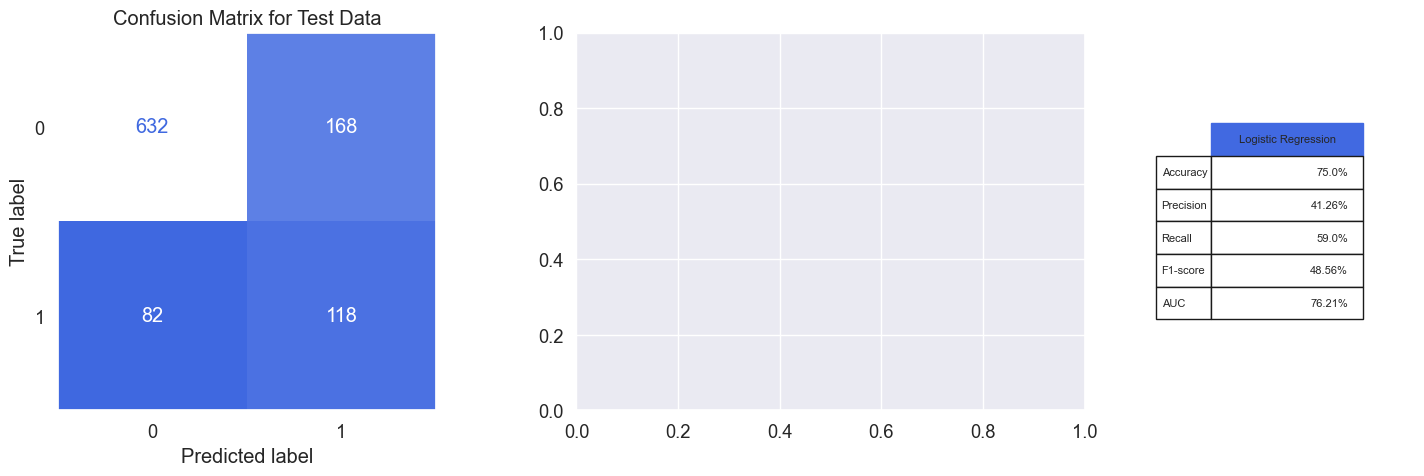

In [144]:

model_evaluation(logreg_opt, X_train, X_test, y_train, y_test, 'Logistic Regression')


In [ ]:
# rand

## random forest 

In [298]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': np.arange(5, 12),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': class_weights
}

param_grid = {
    'n_estimators': [50, 100, 150], 
    'class_weight': class_weights
}

In [59]:
# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_opt = tune_clf_hyperparameters(rf, param_grid, X_train, y_train)

Best hyperparameters:
 {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 8, 'class_weight': {0: 0.1061578947368421, 1: 0.8938421052631579}}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.68      0.81      3200
           1       0.43      0.94      0.59       800

    accuracy                           0.74      4000
   macro avg       0.70      0.81      0.70      4000
weighted avg       0.87      0.74      0.76      4000


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       800
           1       0.39      0.81      0.52       200

    accuracy                           0.70      1000
   macro avg       0.66      0.74      0.65      1000
weighted avg       0.83      0.70      0.73      1000



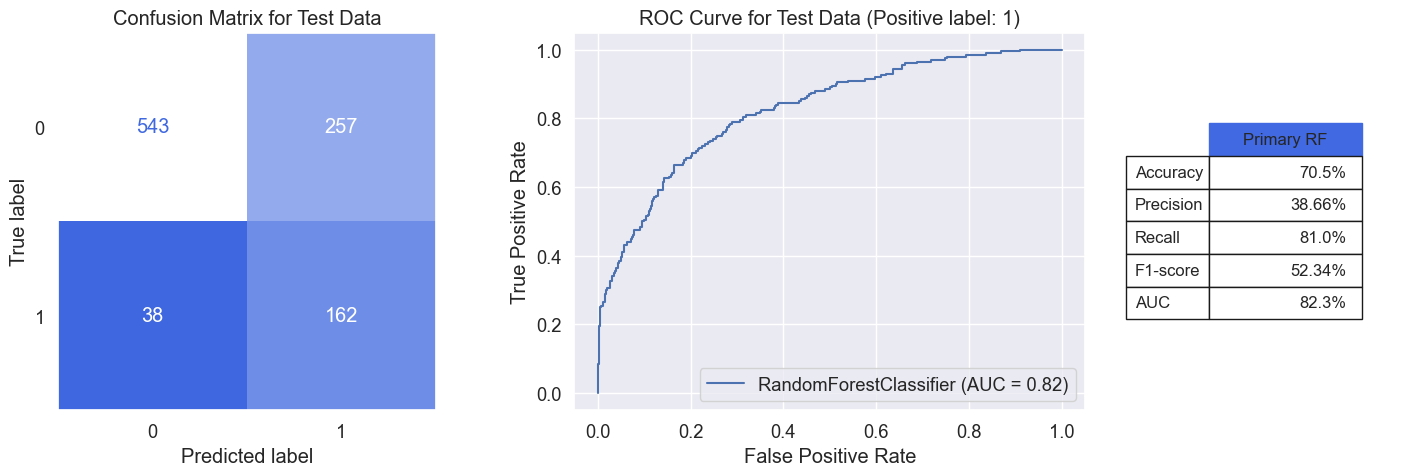

In [60]:
model_evaluation(rf_opt, X_train, X_test, y_train, y_test, 'Primary RF')


## XGboost


In [291]:
# Define imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1) 

# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [1,ratio, ratio*1.3, ratio*1.5, ratio*1.7,ratio*2.5, ratio*3.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}


xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [1,ratio, ratio*1.3, ratio*1.5, ratio*1.7,ratio*2.5, ratio*3.5],
    'subsample': [0.6, 0.8, 1.0]
}
# xgb_param_grid = {

# }

In [305]:
# sampling 

kf = StratifiedKFold(n_splits=5, shuffle=False)
#balancer = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
#balancer = None 
#balancer = RandomUnderSampler(random_state=42)
#balancer =RandomOverSampler(random_state=42)
#balancer = SMOTE(random_state=42)

#X_train_re, y_train_re= balancer.fit_resample(X_train, y_train)

X_train_re, y_train_re = X_train, y_train

In [168]:
# Initialize the XGBoost Classifier
xgb= XGBClassifier(random_state=10)

# Train the XGBoost Classifier
xgb_opt = tune_clf_hyperparameters(xgb, xgb_param_grid, X_train_re, y_train_re)


Best hyperparameters:
 {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'scale_pos_weight': 6.0, 'subsample': 0.6}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      3200
           1       0.66      0.99      0.79       800

    accuracy                           0.90      4000
   macro avg       0.83      0.93      0.86      4000
weighted avg       0.93      0.90      0.90      4000


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       800
           1       0.50      0.69      0.58       200

    accuracy                           0.80      1000
   macro avg       0.71      0.76      0.72      1000
weighted avg       0.83      0.80      0.81      1000



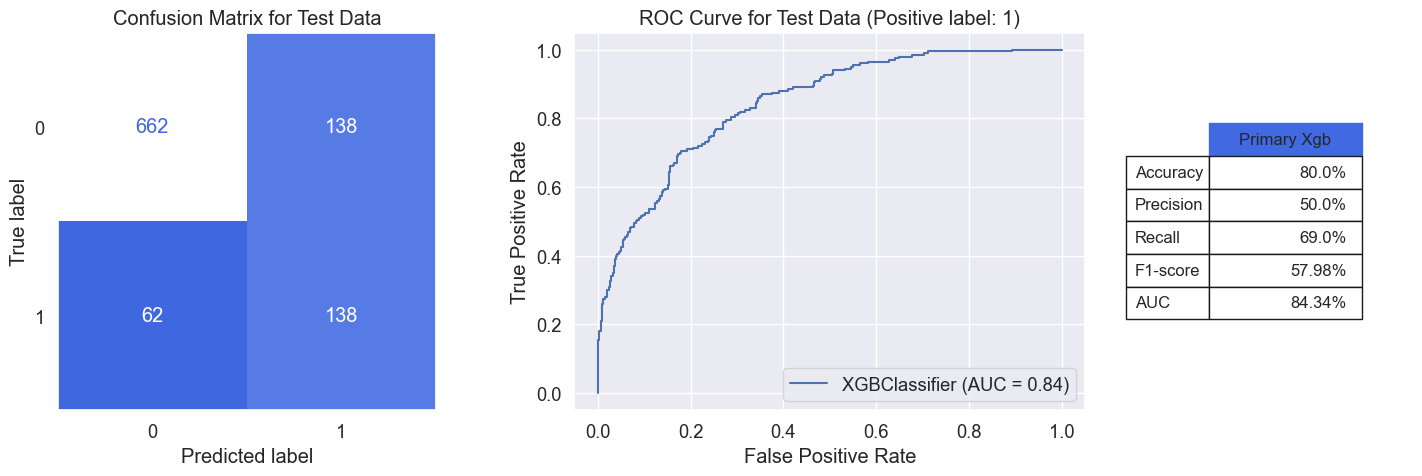

In [169]:
model_evaluation(xgb_opt, X_train_re, X_test, y_train_re, y_test, 'Primary Xgb')



## Extra Trees 

In [212]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70, 100, 150], 
    'max_depth': [10,12,14],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3],
    'class_weight': class_weights
}


# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70,150], 
    'max_depth': [10,14],
    'min_samples_split': [1,3],
    'min_samples_leaf': [1,3],
    'class_weight': class_weights
}


In [213]:
# sampling 

#balancer = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
#balancer = None 
#balancer = RandomUnderSampler(random_state=42)
#balancer =RandomOverSampler(random_state=42)
#balancer = SMOTE(random_state=42)

#X_train_re, y_train_re= balancer.fit_resample(X_train, y_train)

X_train_re, y_train_re = X_train, y_train

In [214]:
# Create a random forest classifier object
et = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
et_opt = tune_clf_hyperparameters(et, param_grid, X_train_re, y_train_re)

Best hyperparameters:
 {'class_weight': {0: 0.15873684210526315, 1: 0.8412631578947368}, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 70}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3200
           1       0.72      0.89      0.79       800

    accuracy                           0.91      4000
   macro avg       0.84      0.90      0.87      4000
weighted avg       0.92      0.91      0.91      4000


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       800
           1       0.52      0.54      0.53       200

    accuracy                           0.81      1000
   macro avg       0.70      0.71      0.71      1000
weighted avg       0.81      0.81      0.81      1000



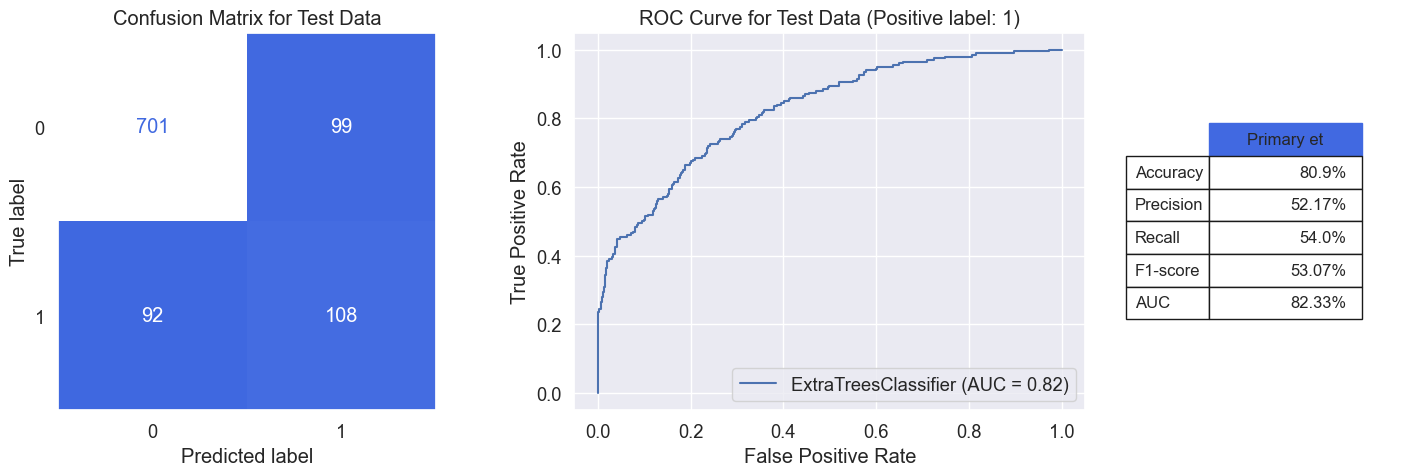

In [216]:
model_evaluation(et_opt, X_train_re, X_test, y_train_re, y_test, 'Primary et')


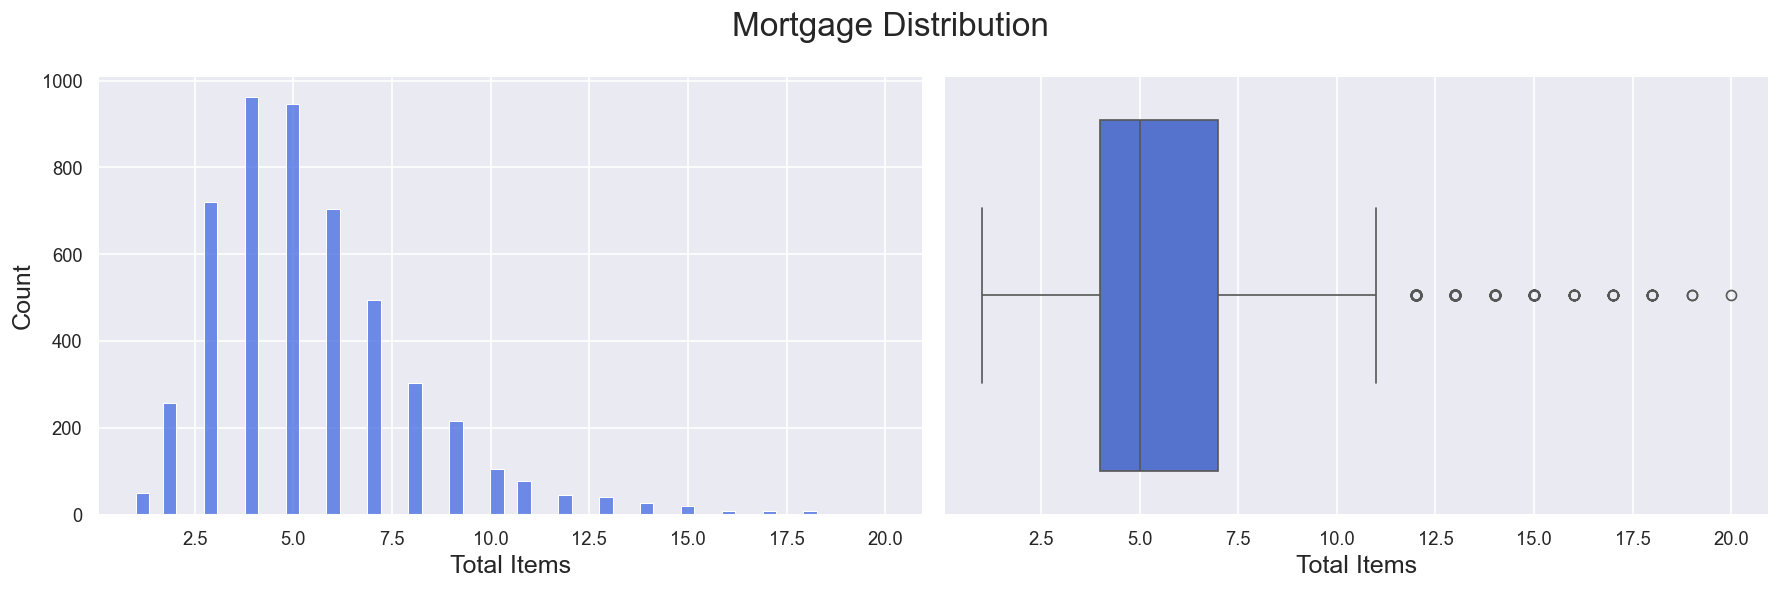

In [310]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Total Items', data=df, color='royalblue', ax=ax[0])
sns.boxplot(x='Total Items', data=df, color='royalblue', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [313]:
from scipy import stats

df[stats.zscore(df['Total Items'])>3]['Total Items'].count()


76